# BLAST Search on DNA Sequences

## Imports

### Importing Required Packages

In [2]:
# Data Analysis Tools
import numpy as np
import pandas as pd
import re

# Visualization Tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Packages for BLAST
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import Entrez, SeqIO

# The let us keep track of time
import time
from datetime import datetime
import concurrent.futures

### Importing Data

Import the saved sequence_analysis_data. This lets us run from here on (except for the package import).

In [44]:
sequence_analysis_data = pd.read_excel(
        "data//checkpoint_data/sequence_analysis_with_blast.xlsx ",
        engine="openpyxl"
    )

## Setting up Functions for BLAST Search

We will now run out DNA sequences through BLAST by using the biopython package. The database will be the nucleotide database from NCBI (called "nt" for short), while "blastn" specifies that we're using the nucleotide BLAST algorithm. We will use the Sequences (No Header) column for this purpose.

To send the query to NCBI, we first set our user address to identify ourselves.

Next, we will define a function that retrieves the key metrics returned from the BLAST search for each sequence.

In [45]:
# Set your email address so NCBI knows who is making requests
Entrez.email = "amoulart@ethz.ch"

In [55]:
def blast_sequence(seq):
    """
    Run a BLAST search on a given DNA sequence and extract key metrics for phylogenetic analysis.

    Returns a dictionary with the following keys:
      - query_id: The ID or description of the query sequence.
      - query_length: The number of nucleotides in the query.
      - hit_accession: The accession number of the top BLAST hit.
      - hit_def: The full definition (description) of the top hit.
      - e_value: The expect value of the top alignment.
      - bit_score: The bit score of the top alignment.
      - alignment_length: The length of the aligned region.
      - identities: The number of identical positions in the alignment.
      - percent_identity: The percentage of identities in the alignment.
      - query_coverage: The percentage of the query sequence covered by the alignment.
      - organism: The organism name from the GenBank record.
      - taxonomy: The taxonomy list from the GenBank record.
      - genbank_sequence_length: The total length of the sequence from GenBank.
      - submission_date: The date the GenBank record was submitted.
      - references: A concatenated string of reference titles.
    """






    try:
        # Run the BLAST query using blastn against the nt database
        # Submit the BLAST query for the input sequence and get the result handle.
        result_handle = NCBIWWW.qblast("blastn", "nt", seq)

        # Parse the XML output returned by BLAST into a Python object.
        blast_record = NCBIXML.read(result_handle)

        # Extract query-level information from the BLAST record
        # Assign the query ID. If blast_record has an attribute query_id, use it;
        # otherwise, fall back to using the query description.
        query_id = blast_record.query_id if hasattr(blast_record, "query_id") else blast_record.query

        # Assign the query length (number of letters in the query).
        query_length = blast_record.query_letters

        # Check if there are any alignments (hits) found.
        if not blast_record.alignments:
            return None  # Return None if no hits are found.

        # Extract the top BLAST hit and its alignment metrics
        # Take the top alignment (first hit from the BLAST results).
        top_alignment = blast_record.alignments[0]

        # Take the first high-scoring pair (HSP) from the top alignment.
        top_hsp = top_alignment.hsps[0]

        # Assign the accession number from the top hit.
        accession = top_alignment.accession

        # Assign the full definition (description) of the top hit.
        hit_def = top_alignment.hit_def

        # Assign the E-value (statistical significance) of the alignment.
        e_value = top_hsp.expect

        # Assign the bit score of the alignment.
        bit_score = top_hsp.bits

        # Assign the length of the alignment region.
        alignment_length = top_hsp.align_length

        # Assign the number of identical positions in the alignment.
        identities = top_hsp.identities

        # Calculate the percent identity; check to avoid division by zero.
        percent_identity = (identities / alignment_length * 100) if alignment_length > 0 else 0.0

        # Calculate the query coverage (percentage of the query sequence that is aligned).
        query_coverage = (alignment_length / query_length * 100) if query_length > 0 else 0.0

        # Fetch the full GenBank record using the accession number
        # Retrieve the GenBank record for the top hit via Entrez.
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        handle.close()

        # Extract GenBank record information
        # Assign the organism name from the GenBank record.
        organism = record.annotations.get("organism", "Unknown")

        # Assign the taxonomy list from the GenBank record.
        taxonomy = record.annotations.get("taxonomy", [])

        # Assign the total length of the GenBank sequence.
        genbank_sequence_length = len(record.seq)

        # Assign the submission or update date from the GenBank record.
        submission_date = record.annotations.get("date", "Unknown")

        # Extract references information from the GenBank record
        # Build a list of reference titles from the record; each reference object has a title attribute.
        references_list = []
        for ref in record.annotations.get("references", []):
            if hasattr(ref, "title"):
                references_list.append(ref.title)

        # Join all reference titles into a single string separated by semicolons.
        references = "; ".join(references_list) if references_list else "None"

        # Construct the final dictionary with all extracted metrics
        result_dict = {
            "query_id": query_id,
            "query_length": query_length,
            "hit_accession": accession,
            "hit_def": hit_def,
            "e_value": e_value,
            "bit_score": bit_score,
            "alignment_length": alignment_length,
            "identities": identities,
            "percent_identity": percent_identity,
            "query_coverage": query_coverage,
            "organism": organism,
            "taxonomy": taxonomy,
            "genbank_sequence_length": genbank_sequence_length,
            "submission_date": submission_date,
            "references": references,
        }

    except Exception as error:
        # If a sequence number was provided, include it in the error message.
        print(f"Error while processing a sequence: {error}")
        # We need to return an empty dictionary if there is a problem with the query.
        # Otherwise, we would  have a problem with identifying missing results later.
        result_dict = {
            "query_id": None,
            "query_length": None,
            "hit_accession": None,
            "hit_def": None,
            "e_value": None,
            "bit_score": None,
            "alignment_length": None,
            "identities": None,
            "percent_identity": None,
            "query_coverage": None,
            "organism": None,
            "taxonomy": None,
            "genbank_sequence_length": None,
            "submission_date": None,
            "references": None,
        }







    # Return the dictionary containing all the desired metrics
    return result_dict


An inconvenient aspect of sending our queries to the NCBI servers is that network errors can occur, which can interrupt the entire loop we set up below to BLAST all sequences. One way this could be improved would be to implement a timeout after a certain period of time has passed.

Note: This turned out not to be feasible, as the nature of the network errors was such that no further line in the code was read and executed, all while the process kept running without doing anything. As such, any control flow that I attempted to implement was not even executed and thus proved to be of no use. The only way forward I see is to run the BLAST search locally, which will be tricky as the nt database exceeds 600 GB in terms of size.

In [1]:
def blast_query_time_manager(seq, seq_num=None, timeout_seconds=180, wait=2):

    # record starting time
    # this is done as a timestamp that is not useful for a human
    start_time = time.time()

    # Convert to a datetime object
    start_dt = datetime.fromtimestamp(start_time)
    # Format it to make it understandable
    # %d = day, %m = month, %H Hour (0-24), %M and %S = minutes and seconds
    formatted_time = start_dt.strftime("%d.%m - %H:%M:%S")


    # Print the sequence number if provided
    if seq_num is not None:
        print(f"Starting BLAST for sequence #{seq_num}\nCurrent time: {formatted_time}.")
    else:
        print(f"Starting BLAST for sequence (unknown number)\nCurrent time: {formatted_time}.")


    # we run our main blast function here and save the returned dictionary
    try:
        result_dict = blast_sequence(seq)

    # This block catches any other exceptions that may occur during the execution of blast_sequence.
    # We log the error and set the result dictionary sd empty to indicate an error occurred.
    except Exception as error:
        print(f"Error while processing sequence: {error}")
        result_dict = {
            "query_id": None,
            "query_length": None,
            "hit_accession": None,
            "hit_def": None,
            "e_value": None,
            "bit_score": None,
            "alignment_length": None,
            "identities": None,
            "percent_identity": None,
            "query_coverage": None,
            "organism": None,
            "taxonomy": None,
            "genbank_sequence_length": None,
            "submission_date": None,
            "references": None,
        }

    # now we report the time that has passed during our query
    # indicate the time it took to run the sequence
    elapsed = time.time() - start_time
    print(f"BLAST completed in {elapsed:.2f} seconds.\n")

    # Wait for a set amount of time before proceeding (In seconds).
    # This is considered good practice when making requests from an online database.
    time.sleep(wait)

    return result_dict

The following is a simple test for the first sequence, letting us see the output of blast_sequence.

In [62]:
# subset = sequence_analysis_data.head(1).copy()

# result = blast_query_time_manager(subset["Sequence (No Header)"].iloc[0])

# result

The next function we define takes a chunk of the sequence database and runs our blast_sequence function on each sequence within it.

The output is assigned to each row in columns that correspond to the dictionary returned by the function.

Finally, the updated database is saved after the entire chunk has been processed.

In [63]:
# Define a helper function to process one chunk of the DataFrame
def process_chunk(df, start, end):
    """
    Process a subset of the DataFrame from index 'start' to 'end'.

    For each row in this chunk (based on the "Sequence (No Header)" column),
    we run the BLAST search and fetch additional GenBank metrics using the
    blast_sequence function (or your similar function). The results
    are stored in new columns of the original DataFrame.

    Parameters:
        df (pd.DataFrame): The full DataFrame to update.
        start (int): The starting index of the chunk.
        end (int): The ending index (non-inclusive) of the chunk.

    Returns:
        df (pd.DataFrame): The updated DataFrame with new columns filled in for the chunk.
    """
    # Extract a copy of the chunk to work on, to avoid modifying a view
    chunk = df.iloc[start:end].copy()

    # For each sequence in the chunk, run the BLAST function we wrote.
    # The function returns a dictionary of metrics, which we convert into a Series.
    # The lambda function wraps each dictionary in pd.Series(), converting it into a pandas Series.
    # This conversion automatically assigns dictionary keys as column names
    # Use apply on each row so that we can pass the row's index as the sequence number.
    results = chunk.apply(
        lambda row: pd.Series(blast_query_time_manager(row["Sequence (No Header)"], seq_num=row.name)),
        axis=1
    )

    # For each column in the result, assign it back to the corresponding rows in the original DataFrame.
    for col in results.columns:
        df.loc[chunk.index, col] = results[col]

    # Return the updated DataFrame
    return df

## Running BLAST Search

IMPORTANT NOTE: This is the version of our blast search that sends queries to the NCBI servers directly.

Unfortunately, it proved to be impossible to use this method to retrieve information for all 8000+ sequences, as the code will freeze due to what is likely to be IP throttling caused by the large amount of requests being sent. This would require a manual reboot every 10-20 sequences, which is naturally not feasible given the volume involved.
Hence, we will have to transition to a local blast on the HPC instead.

In [ ]:
# We set a starting point for a loop, as well as the chunk size (after which the database is saved as an Excel file).
# Some messages are also added so that we can keep track of where the loop is.

# We'll set up an index from which the sequences will be analyzed
# This is useful if the run is interrupted, so that we can pick up from where it left of.
starting_index = 0

# Set your chunk size (for example, 50 sequences at a time)
chunk_size = 10

# Loop over the DataFrame in chunks
# The first iteration processes rows 0–9 (since 0 to 10 non-inclusive).
# The second iteration processes rows 10–19, etc.
# This works because start increases in steps of 10: 0, 10, 20 etc.
# Then the chunk size is added to mark the end of each iteration
for start in range(starting_index, len(sequence_analysis_data), chunk_size):
    end = start + chunk_size  # Define the end index for the current chunk
    print(f"Processing sequences {start} to {end}...\n")

    # Process the current chunk and update the original DataFrame
    sequence_analysis_data = process_chunk(sequence_analysis_data, start, end)

    # We will save the progress after each chunk to avoid losing data in case of an interruption
    sequence_analysis_data.to_excel("data/checkpoint_data/sequence_analysis_with_blast.xlsx", index=False)
    print(f"Chunk {start} to {end} processed and saved.")

# After the loop finishes, the DataFrame should have additional columns with the metrics.
print("All chunks processed!")

Processing sequences 0 to 10...

Starting BLAST for sequence #0
Current time: 20.03 - 16:09:12.


## Local BLAST Setup

Due to the frequent server timeouts and slow speed (probably due to IP address throttling by NCBI's servers due to the excess of requests), we will run the BLAST search on the WSL's high performance cluster (HPC) called Hyperion.

The nt database has been installed but the code needs some readjustment before this can be done. Importantly, I will need to write my code in a python script as the HPC cannot run this notebook.

This section is more for the relevant setup.

### Writing Sequences into Multi-FASTA file

The local BLAST tools require a FASTA file as input, so we now construct such a file by integrating all the sequences from our Sequence (Header) column in the correct format.

We can use the SeqIO tool to parse and analyze the .fasta file later to make sure it was generated correctly later on.

In [40]:
# loading database containing sequences
sequence_analysis_data = pd.read_excel("data/checkpoint_data/sequence_analysis_data.xlsx", engine="openpyxl")

In [4]:
# checking how many sequences we have
print(len(sequence_analysis_data["Sequence (Header)"]))

8399


In [5]:
# Open a file for writing the multi-FASTA file
with open("data/checkpoint_data/sequences_16_24_multi_fasta.fasta", "w") as outfile:
    # Loop over each entry in the "Sequence (Header)" column
    for sequence in sequence_analysis_data["Sequence (Header)"]:
        # Count how many times a header marker ">" occurs in the entry.
        if sequence.count('>') > 1:
            print(f"Skipping multi-record entry: {sequence[:50]}...")
            continue  # skip this entry after printing message
        else:
            # if there is only one ">" character as expected, write the sequence into our .fasta file
            outfile.write(sequence.strip() + "\n")


Skipping multi-record entry: >PHPa_2016_214
TCAACCAATCATAAAGATATTGGGACTTTATATTT...
Skipping multi-record entry: >PHPa_2016_215
TTGTGGGTACAACTTTTTCACTTTTAATTAGAATG...
Skipping multi-record entry: >PHPa_2016_453
TGCTAAGGCGAGTCCTTTGAAAAGTAGGACGTGTT...
Skipping multi-record entry: >PHPa_2016_455
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_458
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_459
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_462
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_463
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_468
CATTACCACACCTAAAACTGTCCACGTGAACTGTG...
Skipping multi-record entry: >PHPa_2016_470
GTACGCAGTCATCAGCTTGCATTGATTACGTCCCT...
Skipping multi-record entry: >PHPa_2016_471
GTACGCAGTCATCAGCTTGCATTGATTACGTCCCT...
Skipping multi-record entry: >PHPa_2016_472
TACGCAGTCATCAGCTTGCATTGATTACGTCCCTG...
Skip

We now perform a short check on the .fasta file we wrote to see how many sequences were written inside (compared to the original amount in the database)

In [27]:
from collections import Counter
from Bio import SeqIO

fasta_file_path = "data/checkpoint_data/sequences_16_24_multi_fasta.fasta"
sequence_count = sum(1 for _ in SeqIO.parse(fasta_file_path, "fasta"))
print(f"Number of sequences: {sequence_count}")

Number of sequences: 8289


Next, we need to check the FASTA file for characters that shouldn't be there as for example an unexpected hyphen in the sequence can break out BLAST script.

When this occurs, we remove the cell from our .fasta file.

An overview of the invalid characters found in sequences is also available.

In [29]:

# Allowed characters for unaligned DNA sequences. This includes the full extended IUPAC set (including ACGTU but also things like SHKYRMW)
allowed_chars = set("ACGTURYSWKMBDHVNacgturyswkmbdhvn")


def check_fasta(file_path):
    total_records = 0
    valid_records = []
    invalid_records = 0
    overall_invalid = Counter()
    overall_hyphens = 0

    # we will use SeqIO's .parse method to analyze our fasta file
    # this lets us access sequence attributes such as the header conveniently if needed
    for record in SeqIO.parse(file_path, "fasta"):
        total_records += 1
        seq = str(record.seq)
        counts = Counter(seq)

        # find out about hyphens specifically (because I originally noticed this issued when a hyphen popped up)
        hyphen_count = counts.get('-', 0)
        overall_hyphens += hyphen_count

        # Collect any characters not in the allowed set
        # counts.items() from collections module is used to hold the frequency of each character in the sequence (where item/value pairs are (character, count))
        # so we set up our own "invalid" dictionary with characters not in our allowed_chars list as keys, and how often they pop up as values
        invalid = {character: count for character, count in counts.items() if character not in allowed_chars}
        overall_invalid.update(invalid)


        if invalid:
            # Print a summary of invalid characters if the sequence is invalid
            print(f"\n{record.id}: len={len(seq)}, invalid={"Yes" if invalid else 'No'}")

            # then update invalid records
            invalid_records += 1
            print(f"Excluding {record.id}: invalid characters {invalid}")
        else:
            valid_records.append(record)

    print(f"\nProcessed {total_records} records.")
    print(f"Invalid records: {invalid_records}")
    print(f"Total hyphens: {overall_hyphens}")
    print(f"Overall invalid characters: {dict(overall_invalid) if overall_invalid else 'None'}")

    return valid_records

valid_sequences = check_fasta("data/checkpoint_data/sequences_16_24_multi_fasta.fasta")



PHPa_2016_12: len=599, invalid=Yes
Excluding PHPa_2016_12: invalid characters {'-': 4}

PHPa_2016_15: len=614, invalid=Yes
Excluding PHPa_2016_15: invalid characters {'-': 1}

PHPa_2016_18: len=499, invalid=Yes
Excluding PHPa_2016_18: invalid characters {'-': 3}

PHPa_2016_275: len=477, invalid=Yes
Excluding PHPa_2016_275: invalid characters {'-': 1}

PHPa_2016_313: len=580, invalid=Yes
Excluding PHPa_2016_313: invalid characters {'-': 1}

PHPa_2016_515: len=386, invalid=Yes
Excluding PHPa_2016_515: invalid characters {'P': 2, '1': 2, '6': 1, '_': 4, '0': 2, '4': 1, '8': 1, 'O': 1, 'X': 1, 'L': 1, 'e': 1, 'p': 1}

PHPa_2016_516: len=517, invalid=Yes
Excluding PHPa_2016_516: invalid characters {'P': 2, '1': 3, '6': 1, '_': 4, '0': 1, '4': 1, '8': 1, 'O': 1, 'X': 1, 'L': 1, 'e': 1, 'p': 1}

PHPa_2016_517: len=614, invalid=Yes
Excluding PHPa_2016_517: invalid characters {'P': 2, '1': 2, '6': 1, '_': 4, '0': 1, '4': 1, '8': 1, '2': 1, 'O': 1, 'X': 1, 'L': 1, 'e': 1, 'p': 1}

PHPa_2016_518

We now save the cleaned out sequences to a new fast file named:

clean_sequences_16_24_MultiFasta.fasta

This is the final sequence repository that we are now going to pass to our blast search.

In [78]:
# Write the valid sequences to a new FASTA file

output_file = "data/checkpoint_data/clean_sequences_16_24_MultiFasta.fasta"
# because SeqIO is keeping these sequences in an organized format, I can use the SeqIO.write() method to generate a new FASTA file containing only valid DNA sequences
with open(output_file, "w") as out_handle:
    SeqIO.write(valid_sequences, out_handle, "fasta")

print(f"\nWrote {len(valid_sequences)} valid sequences to {output_file}")


Wrote 8233 valid sequences to data/checkpoint_data/clean_sequences_16_24_MultiFasta.fasta


Double checking that the fast file has the correct amount of sequences (it should match the above value):

In [80]:
file_path = "data/checkpoint_data/clean_sequences_16_24_MultiFasta.fasta"
sequence_count = sum(1 for _ in SeqIO.parse(file_path, "fasta"))
print(f"Number of sequences: {sequence_count}")

Number of sequences: 8233


# Processing BLAST Results

## OUTDATED

Old BLAST search without available sequence headers

This section deals with retrieving the results from the local BLAST search that was run on WSL's HPC Hyperion. The multi fasta file was used with blastn, comparing sequences to the nt database from NCBI.

The sequences were blasted in batches of 100, for a total of 83 batches. Each batch returned a .xml file, and all these files were then read and the relevant information about each sequence saved to an excel file, which is now saved in the project environment as blast_results.xlsx.

However, we still need to sort the results in a way that will allow us to merge them with our original dataset (currently saved as sequence_analysis_data.xlsx.

This is necessary because the blastn command used to run the BLAST search defaults to saving a sequence ID as "Query_<counter>", which works just fine for a single search, but becomes problematic when splitting it into batches (as each one will have the same naming scheme and thus sequence IDs are not unique anymore).

So, the .xml result extraction script was modified to attach the file name (which has the batch number).
For example, the first entries' sequence IDs look like this:
blast_results_batch_27.xml_Query_1
blast_results_batch_27.xml_Query_2

Now, we can retrieve the batch number and then query ID, and sort all sequences before mapping the results back to the sequence with header that we used for the blast search.

### Sorting Batches in Result Excel File

In [1]:
import pandas as pd
import re

.We first define a function that retrieves the batch number and query number.

Then, we apply it to the Excel file and save that information in two new columns that we can use to sort the rows.

In [3]:
def extract_batch_and_query(query_id):
    """
    Extracts the batch number and query number from a query_id string.

    Example input: "blast_results_batch_27.xml_Query_1"
    Returns: (27, 1)
    """
    # Extract the batch number from the pattern 'batch_<number>.xml'
    # the \d+ format string is used to capture the variable batch number and later query number
    # \d matches any single digit, while adding + makes it match "one or more", i.e. all digits at that spot
    # re.search looks for any such match in the query_id (function input) and saves it to a variable
    batch_match = re.search(r'batch_(\d+)\.xml', query_id)
    # Extract the query number from the pattern '_Query_<number>'
    query_match = re.search(r'_Query_(\d+)', query_id)

    # the use of .group(1) lets us retrieve the number portion from our match
    # this is then converted to an integer (relevant since we will want to sort the df numerically later on)
    # .group() or .group(0) would return the entire matched string
    # Increasing the number returns the capture groups in order, so .group(1) will return the content of (\d+), i.e. the number
    batch_num = int(batch_match.group(1)) if batch_match else None
    query_num = int(query_match.group(1)) if query_match else None
    return batch_num, query_num


# save the Excel file as a python object
blast_results = pd.read_excel("data/raw_data/blast_results.xlsx")

# use .apply with the extraction function to create 'batch_num' and 'query_num' columns for each entry
# we use a temporary function to turn the output into a pd.Series object, which is compatible with .apply
blast_results[['batch_num', 'query_num']] = blast_results['query_id'].apply(
    lambda x: pd.Series(extract_batch_and_query(x)))

blast_results

,query_id,query_length,hit_accession,hit_def,e_value,bit_score,alignment_length,identities,percent_identity,query_coverage,organism,taxonomy,genbank_sequence_length,submission_date,references,batch_num,query_num
0,blast_results_batch_27.xml_Query_1,757,KX618545,Armillaria gallica strain CW51 internal transc...,0.0,1399.030,757.0,757.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,27,1
1,blast_results_batch_27.xml_Query_2,755,KX618545,Armillaria gallica strain CW51 internal transc...,0.0,1389.800,756.0,755.0,99.867725,100.132450,Not Available,Not Available,Not Available,Not Available,Not Available,27,2
2,blast_results_batch_27.xml_Query_3,567,PV199098,Diplodia sapinea culture VKM:F 1176 small subu...,0.0,1048.170,567.0,567.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,27,3
3,blast_results_batch_27.xml_Query_4,550,MT587369,Diplodia sapinea culture CPC:32394 small subun...,0.0,1016.780,550.0,550.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,27,4
4,blast_results_batch_27.xml_Query_5,564,MT587369,Diplodia sapinea culture CPC:32394 small subun...,0.0,1042.630,564.0,564.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,27,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,blast_results_batch_70.xml_Query_96,610,OQ685551,Anisandrus maiche voucher PHP22_0627 cytochrom...,0.0,1107.260,611.0,606.0,99.181669,100.163934,Not Available,Not Available,Not Available,Not Available,Not Available,70,96
8233,blast_results_batch_70.xml_Query_97,644,OR544797,Anisandrus maiche voucher E23_53_3 cytochrome ...,0.0,1182.980,644.0,642.0,99.689441,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,70,97
8234,blast_results_batch_70.xml_Query_98,591,PQ686368,Anisandrus maiche isolate am3 mitochondrial CO...,0.0,1018.620,591.0,571.0,96.615905,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,70,98
8235,blast_results_batch_70.xml_Query_99,591,MN619846,Anisandrus maiche isolate SAX280 cytochrome ox...,0.0,966.918,591.0,557.0,94.247039,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,70,99


Now, we can use those two new metrics to sort the dataset in the order in which the BLAST search was executed.

In [4]:
# now use the new column info to sort the rows
# .sort_values sorts a DataFrame by one or more columns
# this is done by passing either a single column or, as we did here, a list of columns to the "by" parameter
# here, it takes a first priority (batch_num) and a second priority (query_num)
# inplace=True modifies the original df, instead of returning a sorted copy
# this does NOT mean that the Excel file is changed, so we need to save the new object later
blast_results.sort_values(by=['batch_num', 'query_num'], inplace=True)
blast_results

,query_id,query_length,hit_accession,hit_def,e_value,bit_score,alignment_length,identities,percent_identity,query_coverage,organism,taxonomy,genbank_sequence_length,submission_date,references,batch_num,query_num
1000,blast_results_batch_1.xml_Query_1,551,OK661073,Xenoacremonium falcatum isolate 39 small subun...,0.0,998.311,551.0,547.0,99.274047,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,1,1
1001,blast_results_batch_1.xml_Query_2,615,JF289158,Uncultured fungus clone L046938-122-076-A02-un...,0.0,1131.270,615.0,614.0,99.837398,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,1,2
1002,blast_results_batch_1.xml_Query_3,565,KT823780,Gnomoniopsis sp. Gall_18b 18S ribosomal RNA ge...,0.0,1022.320,553.0,553.0,100.000000,97.876106,Not Available,Not Available,Not Available,Not Available,Not Available,1,3
1003,blast_results_batch_1.xml_Query_4,564,MH205921,Diaporthe amygdali isolate CJL862 small subuni...,0.0,1042.630,564.0,564.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,1,4
1004,blast_results_batch_1.xml_Query_5,615,JF289158,Uncultured fungus clone L046938-122-076-A02-un...,0.0,1136.810,615.0,615.0,100.000000,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,blast_results_batch_83.xml_Query_33,484,OP279152,Monochamus galloprovincialis voucher KOU-LMMG4...,0.0,869.046,482.0,476.0,98.755187,99.586777,Not Available,Not Available,Not Available,Not Available,Not Available,83,33
6933,blast_results_batch_83.xml_Query_34,478,OP279151,Monochamus galloprovincialis voucher KOU-LMMG2...,0.0,872.739,478.0,475.0,99.372385,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,83,34
6934,blast_results_batch_83.xml_Query_35,485,KY357724,Monochamus galloprovincialis isolate TX12_22.0...,0.0,878.279,485.0,480.0,98.969072,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,83,35
6935,blast_results_batch_83.xml_Query_36,487,OP279148,Monochamus galloprovincialis voucher KOU-LMMG2...,0.0,893.052,487.0,485.0,99.589322,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available,83,36


Now, we can save the sorted DataFrame to a new Excel file

In [5]:
blast_results.to_excel("data/checkpoint_data/sorted_blast_results.xlsx", index=False)

### Merging Sorted Results with Original DataFrame

First, the original database saved in sequence_analysis_data.xlsx needs to be edited in order to not include the entries for DNA sequences we didn't include in the multi fasta file for our blast search (due to containing letters not part of the IUPAC nomenclature for sequences).

After updating the database, we will merge it with our blast results based on DataFrame size, as the blast results are now ordered correctly.

### Removing entries for invalid DNA sequence from diagnostics database copy

We will use the check_fasta function we wrote during the local blast setup (see "Writing Sequences into Multi-FASTA file" section) to retrieve the entries for sequences we determined as valid and sent to our blast search.

The resulting SeqRecord object is saved in valid_sequences, and has multiple attribute (such as the sequence header) that we can extract and use to index our database.

In [12]:
raw_diagnostics_db_for_merge = pd.read_excel("data/checkpoint_data/sequence_analysis_data.xlsx")

In [13]:
len(raw_diagnostics_db_for_merge)

8399

In [15]:
# First, optionally print the entries that have multiple records (more than one '>')
invalid_entries = raw_diagnostics_db_for_merge[
    raw_diagnostics_db_for_merge["Sequence (Header)"].str.count('>') > 1
]

# Then filter the DataFrame to keep only rows with exactly one '>' character
filtered_diagnostics_db_for_merge = raw_diagnostics_db_for_merge[
    raw_diagnostics_db_for_merge["Sequence (Header)"].str.count('>') == 1
]

# You can verify the change by checking the size of the DataFrame
print(f"Number of entries after filtering: {len(filtered_diagnostics_db_for_merge)}")


Number of entries after filtering: 8289


In [22]:
from collections import Counter

# Allowed characters for unaligned DNA sequences (full extended IUPAC set)
allowed_chars = set("ACGTURYSWKMBDHVNacgturyswkmbdhvn")

def filter_valid_sequences(df, sequence_column):
    """
    Filters a DataFrame to retain only rows with valid sequences and also returns rows that were removed.

    A valid sequence is defined as one that only contains characters present in allowed_chars.
    Rows containing any illegal characters (including hyphens) are removed.

    Parameters:
      df (pd.DataFrame): Input DataFrame containing sequence data.
      sequence_column (str): Name of the column in df that holds the sequences.

    Returns:
      tuple: (valid_df, removed_df)
          valid_df (pd.DataFrame): DataFrame containing only valid sequence rows.
          removed_df (pd.DataFrame): DataFrame containing the rows that were removed.
    """
    total_rows = len(df)
    valid_indices = []
    invalid_indices = []
    overall_invalid = Counter()
    overall_hyphens = 0

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        seq = row[sequence_column]
        counts = Counter(seq)
        hyphen_count = counts.get('-', 0)
        overall_hyphens += hyphen_count

        # Build dictionary of any characters not in allowed_chars
        invalid = {character: count for character, count in counts.items() if character not in allowed_chars}
        overall_invalid.update(invalid)

        # Print a summary of invalid characters if the sequence is invalid
        if invalid:
            print(f"\nRow {index} ({seq[:30]}...): len={len(seq)}, invalid={'Yes' if invalid else 'No'}")

        if invalid:
            invalid_indices.append(index)
            print(f"Excluding row {index}: invalid characters {invalid}")
        else:
            valid_indices.append(index)

    print(f"\nProcessed {total_rows} rows.")
    print(f"Invalid rows: {len(invalid_indices)}")
    print(f"Total hyphens: {overall_hyphens}")
    print(f"Overall invalid characters: {dict(overall_invalid) if overall_invalid else 'None'}")

    # Create DataFrames for valid and invalid (removed) rows.
    valid_df = df.loc[valid_indices].copy()
    removed_df = df.loc[invalid_indices].copy()

    return valid_df, removed_df


# Filter the DataFrame; assume the column with the sequence is named "Sequence (No Header)"
valid_df, removed_df = filter_valid_sequences(filtered_diagnostics_db_for_merge, "Sequence (No Header)")


Row 1 (AGGGATCATTACCGAGTTTACAACTCNCCN...): len=599, invalid=Yes
Excluding row 1: invalid characters {'-': 4}

Row 4 (TCATTAACGAATAACTATGGTGTCTCAGGT...): len=614, invalid=Yes
Excluding row 4: invalid characters {'-': 1}

Row 7 (CTTTTCCTTTGTGCTGGCTTTGACCGTATG...): len=499, invalid=Yes
Excluding row 7: invalid characters {'-': 3}

Row 135 (ATTGNNCNNNNGTANCNTNNGNNNNGAANC...): len=477, invalid=Yes
Excluding row 135: invalid characters {'-': 1}

Row 139 (GGGTCTCCTCCTCCTGCTGGGTCAAAAAAT...): len=640, invalid=Yes
Excluding row 139: invalid characters {'\n': 10}

Row 142 (AATCAGAATAGGTGTTGGTATAAAATTGGG...): len=659, invalid=Yes
Excluding row 142: invalid characters {'\n': 10}

Row 144 (AGGTTTATCAATAAGAGTAATTATTCGTAT...): len=580, invalid=Yes
Excluding row 144: invalid characters {'-': 1}

Row 262 (PHP16_0480_COX_LepR1_RC
TTTGAT...): len=387, invalid=Yes
Excluding row 262: invalid characters {'P': 2, '1': 2, '6': 1, '_': 4, '0': 2, '4': 1, '8': 1, 'O': 1, 'X': 1, 'L': 1, 'e': 1, 'p': 1, '\n': 1}

In [5]:
removed_df.to_excel("data/checkpoint_data/invalid_sequence_entries.xlsx", index=False)

In [17]:
# this string contains allowed characters for each DNA sequence
# below is a quick check to make sure that the criteria used to clean the sequences are the same
# for the fasta function (from the local blast setup section) and the database function from above
print("ACGTURYSWKMBDHVNacgturyswkmbdhvn" == "ACGTURYSWKMBDHVNacgturyswkmbdhvn")

True


In [19]:
# do we have the correct amount of sequences?
# sequences in fasta file for blast search: 8233
print(len(valid_df))

8165


## Merging BLAST Results with Main Database

In [57]:
# load the BLAST results
blast_results = pd.read_excel("data/raw_data/blast_results.xlsx")

# loading original database containing sequences and sample info
sequence_analysis_data = pd.read_excel("data/checkpoint_data/sequence_analysis_data.xlsx", engine="openpyxl")

We need to add a "Header" column to let use conveniently merge both datasets based on the shared header entries.

In [58]:
sequence_analysis_data["Header"] = (
    sequence_analysis_data["Sequence (Header)"]
      .str.split("\n", n=1)    # split at first newline
      .str[0]                   # only save the header part in new column
)
sequence_analysis_data.head()

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,Resultate::Re_Resultat,Resultate::Re_Resultat_von,Resultate::Re_Systemdatum,Primer Category,PCR Primer,Year,Sequencing Method,Sequence (No Header),Sequence (Header),Header
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,Fungi,"ITS1F & ITS4 (F spezifisch, Fungi)",2016,Barcode Sequencing,CGGAGGGATCATTACCGAGTTATCAACTCCCCAAACCCCTGTGAAC...,>PHPa_2016_11\nCGGAGGGATCATTACCGAGTTATCAACTCCC...,>PHPa_2016_11
1,Joana Meyer,NaN,NaN,PHP16_0012,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,Fungi,ITS1 & ITS4 (Fungi/Plants),2016,Barcode Sequencing,AGGGATCATTACCGAGTTTACAACTCNCCNAACNNCNATGTGAANC...,>PHPa_2016_12\nAGGGATCATTACCGAGTTTACAACTCNCCNA...,>PHPa_2016_12
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,Fungi,ITS1 & ITS4 (Fungi/Plants),2016,Barcode Sequencing,GCGGAAGGATCATTAACGAGTTTTGAAAGGGGTTGTCGCTGGCCTT...,>PHPa_2016_13\nGCGGAAGGATCATTAACGAGTTTTGAAAGGG...,>PHPa_2016_13
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,Fungi,ITS1 & ITS4 (Fungi/Plants),2016,Barcode Sequencing,TGCGGAGGGATCATTGCTGGAACAAACGCCCTCACGGGTGCTACCC...,>PHPa_2016_14\nTGCGGAGGGATCATTGCTGGAACAAACGCCC...,>PHPa_2016_14
4,Joana Meyer,NaN,NaN,PHP16_0015,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,Fungi,ITS1 & ITS4 (Fungi/Plants),2016,Barcode Sequencing,TCATTAACGAATAACTATGGTGTCTCAGGTTGTAGCTGGCTCCTCG...,>PHPa_2016_15\nTCATTAACGAATAACTATGGTGTCTCAGGTT...,>PHPa_2016_15


In [59]:
# get the two sets of headers
main_headers  = set(sequence_analysis_data["Header"])
# Note: blast_results' "query_id" column contains headers without ">", so we need to add one to let it match the original header format
blast_headers = set(">" + blast_results["query_id"])

# use DataFrame versin of AND operator to figure out which headers are in both datasets
shared_headers = main_headers & blast_headers

print(f"""
Unique headers in original dataset: {len(main_headers)}
Unique headers in blast results: {len(blast_headers)}

Unique headers in common: {len(shared_headers)}
""")

# Now we run a final check that doesn't check for unique matches.
matches_in_main = sequence_analysis_data["Header"].isin(">" + blast_results["query_id"]).sum()
print(f"Rows in main DF with a matching BLAST header: {matches_in_main}")


Unique headers in original dataset: 8381
Unique headers in blast results: 8215

Unique headers in common: 8215

Rows in main DF with a matching BLAST header: 8233


### Remove duplicate Headers

This works to remove duplicates from sequence_analysis_data, but the process could use some refining. Ultimately, this section still needs to be run to successfully perform the merge below.

In [61]:
# Flag all rows where 'Header' is duplicated
dupes = sequence_analysis_data[
    sequence_analysis_data["Header"].duplicated(keep=False) # this part creates a boolean mask (keep=False marks every occurrence)
]

# figure out amount of duplicate rows (counts both duplicates, so if there are two of each it would be half the number shown here)
total_dupes = len(dupes)
print(f"Found {total_dupes} duplicate rows.")

dupes


Found 36 duplicate rows.


,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,Resultate::Re_Resultat,Resultate::Re_Resultat_von,Resultate::Re_Systemdatum,Primer Category,PCR Primer,Year,Sequencing Method,Sequence (No Header),Sequence (Header),Header
1165,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTTCACGTGAACCGTATCAACCCTTTTAG...,>PHPa_2017_3226\nTTACCACACCTAAAACTTTTCACGTGAAC...,>PHPa_2017_3226
1166,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTTCACGTGAACCGTATCAACCCTTTTAG...,>PHPa_2017_3226\nTTACCACACCTAAAACTTTTCACGTGAAC...,>PHPa_2017_3226
1167,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTTCACGTGAACCGTATCAACCCTTTTAG...,>PHPa_2017_3227\nTTACCACACCTAAAACTTTTCACGTGAAC...,>PHPa_2017_3227
1168,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTTCACGTGAACCGTATCAACCCTTTTAG...,>PHPa_2017_3227\nTTACCACACCTAAAACTTTTCACGTGAAC...,>PHPa_2017_3227
1169,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAAAACTTTCCACGTGAACCGTATCAACCCCTAT...,>PHPa_2017_3229\nTTACCACACCTAAAAAACTTTCCACGTGA...,>PHPa_2017_3229
1170,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAAAACTTTCCACGTGAACCGTATCAACCCCTAT...,>PHPa_2017_3229\nTTACCACACCTAAAAAACTTTCCACGTGA...,>PHPa_2017_3229
1171,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAAACTTTCCACGTGAACCGTATCAACCCCTATA...,>PHPa_2017_3234\nTTACCACACCTAAAAACTTTCCACGTGAA...,>PHPa_2017_3234
1172,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAAACTTTCCACGTGAACCGTATCAACCCCTATA...,>PHPa_2017_3234\nTTACCACACCTAAAAACTTTCCACGTGAA...,>PHPa_2017_3234
1173,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTCCACGTGAACCGTATCAACCCCTATAA...,>PHPa_2017_3235\nTTACCACACCTAAAACTTTCCACGTGAAC...,>PHPa_2017_3235
1174,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Oomycetes,"18Ph2F & 28Ph2R (Phytophthora-spezifisch, Oomy...",2017,Barcode Sequencing,TTACCACACCTAAAACTTTCCACGTGAACCGTATCAACCCCTATAA...,>PHPa_2017_3235\nTTACCACACCTAAAACTTTCCACGTGAAC...,>PHPa_2017_3235


In [62]:
# Drop duplicate headers, keeping only the first occurrence
#    - subset="Header" says “look only at this column for duplicates”
#    - keep="first" says “for each group of identical headers, keep the first row”
sequence_analysis_data = sequence_analysis_data.drop_duplicates(
    subset="Header",
    keep="first"
)

# (Optional) See how many you dropped:
dropped = len(sequence_analysis_data) - len(sequence_analysis_data)
print(f"Dropped {dropped} duplicate rows, leaving {len(sequence_analysis_data)} unique headers.")

Dropped 0 duplicate rows, leaving 8381 unique headers.


### Merging Datasets

Until the duplicates are handled, the only option is to do a "one_to_many" left merge, as explained below.

Put simply, this means that as long as the sequence_analysis_data dataset only has unique headers, we can merge successfully despite duplicated blast results.

In [64]:
# Copy the BLAST results to avoid modifying the original DataFrame
blast_to_merge = blast_results.copy()
# Prepend '>' to each query_id so it matches the format in sequence_analysis_data
blast_to_merge["Header"] = ">" + blast_to_merge["query_id"]


# We no longer need the raw query_id column
blast_to_merge = blast_to_merge.drop(columns=["query_id"])

# Perform a left join on the 'Headers' column:
# - sequence_analysis_data is the left table (all its rows are kept)
# - blast_to_merge is the right table (adds BLAST columns where headers match)
merged_sequence_analysis_data = pd.merge(
    sequence_analysis_data,
    blast_to_merge,
    on="Header",            # column to join on (must exist in both frames)
    how="left",              # keep all rows from sequence_analysis_data
    # validate="one_to_one"     # assert that each header appears at most once in each DataFrame
    validate="one_to_many" # allows each left key to match multiple right keys
)


# isna() returns True for NaN entries, sum() counts them
missing_hits = merged_sequence_analysis_data["e_value"].isna().sum()
print(f"{missing_hits} sequences lack a BLAST match (NaN values).")


# For all object (string) columns, replace pandas NaN with literal "NA"
# This can help when exporting to formats that don't handle NaN well
# for col in merged_sequence_analysis_data.select_dtypes(include="object"):
#     merged_sequence_analysis_data[col] = merged_sequence_analysis_data[col].fillna("NA")  # in-place replacement for each column

171 sequences lack a BLAST match (NaN values).


Saving merged database to an Excel file:

In [65]:
merged_sequence_analysis_data.to_excel("data/checkpoint_data/merged_blast_results.xlsx", index=False)

## Test retrieving Organism Data from Accession ID

### Retrieving GenBank Data for Taxonomy Information

We now use the accession IDs obtained during the BLAST search to find taxonomic information form the GenBank database (also hosted by NCBI).

As this operation is computationally very simple (every accession ID is unique and matches exactly one set of data), we won't need to download the database and run it on the HPC.
So, the following retrieves the desired data directly, which is later going to be merged with the original database.

In [75]:
Entrez.email = "amoulart@ethz.ch"

def fetch_metadata(acc_list):
    # Fetch full GenBank records for a list of accessions
    handle = Entrez.efetch(
        db="nucleotide",
        id=",".join(acc_list),   # comma-separated IDs
        rettype="gb",             # GenBank flat file
        retmode="text"
    )
    records = list(SeqIO.parse(handle, "genbank"))
    handle.close()
    return records

# retrieving accession ID list
accessions = (
    merged_sequence_analysis_data["hit_accession"]
        .dropna()           # remove NaN floats
        .astype(str)        # turn everything into strings
        .unique()
        .tolist()           # returns a list
)

# Break accession list into chunks of ~200 so the request URL isn’t enormous
chunks = [accessions[i:i + 200] for i in range(0, len(accessions), 200)]

# Total number of chunks
n_chunks = len(chunks)

# this is where we'll save the records for each accession ID
all_records = []

for batch_idx, chunk in enumerate(chunks, start=1):
    # compute the index of the first and last accession ID in this chunk
    start_idx = (batch_idx - 1) * 200 + 1
    end_idx   = start_idx + len(chunk) - 1

    print(
        f"Fetching batch {batch_idx}/{n_chunks} "
        f"(accessions {start_idx}–{end_idx} of {len(accessions)})…"
    )

    all_records.extend(fetch_metadata(chunk))
    time.sleep(0.34)  # throttle to ~3 requests/sec

# extracting the fields we care about
rows = []
for record in all_records:
    # take record.id (e.g. "MN989069.1") and drop everything from the first dot onward (lets us retrieve a clean accession ID without version numbers for a simple merge)
    core_id = record.id.split(".", 1)[0]
    rows.append({
        "Accession (With Version)": record.id,  # rec.id already includes the version (e.g. “MN989069.1”), updated every time someone updates the GenBank record
        "Accession": core_id,
        "Organism": record.annotations.get("organism", ""),
        "Taxonomy": ";".join(record.annotations.get("taxonomy", [])),
        "Length": len(record.seq),
        "Submission Date": record.annotations.get("date", ""),
        "References": "; ".join(ref.title for ref in record.annotations.get("references", []))
    })

genbank_data_results = pd.DataFrame(rows)

Fetching batch 1/17 (accessions 1–200 of 3323)…
Fetching batch 2/17 (accessions 201–400 of 3323)…
Fetching batch 3/17 (accessions 401–600 of 3323)…
Fetching batch 4/17 (accessions 601–800 of 3323)…
Fetching batch 5/17 (accessions 801–1000 of 3323)…
Fetching batch 6/17 (accessions 1001–1200 of 3323)…
Fetching batch 7/17 (accessions 1201–1400 of 3323)…
Fetching batch 8/17 (accessions 1401–1600 of 3323)…
Fetching batch 9/17 (accessions 1601–1800 of 3323)…
Fetching batch 10/17 (accessions 1801–2000 of 3323)…
Fetching batch 11/17 (accessions 2001–2200 of 3323)…
Fetching batch 12/17 (accessions 2201–2400 of 3323)…
Fetching batch 13/17 (accessions 2401–2600 of 3323)…
Fetching batch 14/17 (accessions 2601–2800 of 3323)…
Fetching batch 15/17 (accessions 2801–3000 of 3323)…
Fetching batch 16/17 (accessions 3001–3200 of 3323)…
Fetching batch 17/17 (accessions 3201–3323 of 3323)…


In [76]:
# saving a copy to excel
genbank_data_results.to_excel("data/checkpoint_data/genbank_phylogenetic_information.xlsx", index=False)

### Renaming Accession Columns for GenBank Data Merge

Since we retrieved the information for each unique ID, we will have to merge "many_to_one", i.e. the same identical accession number will match multiple entries in the original dataset.

Accordingly, we need to make sure that a column containing the accession ID with the same format is present in both datasets, which we accomplish in this section.

In [81]:
genbank_data_results.rename(
    columns={"Accession (Clean)": "Accession"},
    inplace=True
)

genbank_data_results

,Accession (With Version),Accession,Organism,Taxonomy,Length,Submission Date,References
0,OK661073.1,OK661073,Xenoacremonium falcatum,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,605,01-NOV-2022,"Fungal communities associated with ambrosia, b..."
1,JF289158.1,JF289158,uncultured fungus,Eukaryota;Fungi;environmental samples,656,22-AUG-2014,Biogeography in the air: fungal diversity over...
2,KT823780.1,KT823780,Gnomoniopsis sp. Gall_18b,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,553,12-NOV-2015,Interaction between two invasive organisms on ...
3,MH205921.1,MH205921,Diaporthe amygdali,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,627,01-MAY-2019,Development of a qPCR-based method for the det...
4,AJ230662.1,AJ230662,Trichoderma sp. DAOM 172826,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,640,27-APR-2010,What exactly is Trichoderma viride?; Direct Su...
...,...,...,...,...,...,...,...
3318,MF286237.1,MF286237,Agrilus viridis viridis,Eukaryota;Metazoa;Ecdysozoa;Arthropoda;Hexapod...,652,10-JUN-2018,First molecular phylogeny of Agrilus (Coleopte...
3319,OL305842.1,OL305842,Monochamus galloprovincialis,Eukaryota;Metazoa;Ecdysozoa;Arthropoda;Hexapod...,681,31-MAR-2022,Species-specific primers for rapid detection o...
3320,KY357731.1,KY357731,Monochamus galloprovincialis,Eukaryota;Metazoa;Ecdysozoa;Arthropoda;Hexapod...,658,12-FEB-2017,Identification of wood-boring beetles (Ceramby...
3321,KY773691.1,KY773691,Monochamus sartor urussovii,Eukaryota;Metazoa;Ecdysozoa;Arthropoda;Hexapod...,14359,17-JUL-2018,The mitochondrial genome sequencing and phylog...


In [84]:
merged_sequence_analysis_data.rename(
    columns={"hit_accession": "Accession"},
    inplace=True
)

merged_sequence_analysis_data

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,bit_score,alignment_length,identities,percent_identity,query_coverage,organism,taxonomy,genbank_sequence_length,submission_date,references
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,998.311,551.0,547.0,99.274047,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available
1,Joana Meyer,NaN,NaN,PHP16_0012,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,1131.270,615.0,614.0,99.837398,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,1022.320,553.0,553.0,100.000000,97.876106,Not Available,Not Available,Not Available,Not Available,Not Available
4,Joana Meyer,NaN,NaN,PHP16_0015,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,Maurice Moor,2024-08-24 00:00:00,"Leerung 4 (31.07.2024), 7 individuals",PHP24_4318,2024-12-10 11:12:38,mittelst,Diagnostik,St. Gallen,Insektenmaterial,Insekten,...,869.046,482.0,476.0,98.755187,99.586777,Not Available,Not Available,Not Available,Not Available,Not Available
8395,Maurice Moor,2024-08-24 00:00:00,"Leerung 4 (31.07.2024), 7 individuals",PHP24_4319,2024-12-10 11:12:38,mittelst,Diagnostik,St. Gallen,Insektenmaterial,Insekten,...,872.739,478.0,475.0,99.372385,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available
8396,Doris Hölling,2024-10-08 00:00:00,VS_Fö_Ts_A 28.8.2024 (Leerung 5?),PHP24_4348,2024-12-10 11:12:38,mittelst,Diagnostik,VS,Monochamus sp.,Insekten,...,878.279,485.0,480.0,98.969072,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available
8397,Doris Hölling,2024-10-08 00:00:00,VS_Fö_Ts_A 28.8.2024 (Leerung 5?),PHP24_4349,2024-12-10 11:12:38,mittelst,Diagnostik,VS,Monochamus sp.,Insekten,...,893.052,487.0,485.0,99.589322,100.000000,Not Available,Not Available,Not Available,Not Available,Not Available


### GenBank Data Merge

In [87]:
# Perform a left join on the 'Headers' column:
# - sequence_analysis_data is the left table (all its rows are kept)
# - blast_to_merge is the right table (adds BLAST columns where headers match)
final_diagnostics_data = merged_sequence_analysis_data.merge(
    genbank_data_results,
    on="Accession",            # column to join on (must exist in both frames)
    how="left",              # keep all rows from sequence_analysis_data
    validate="many_to_one" # allows each left key to match multiple right keys
)

final_diagnostics_data.head()

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,taxonomy,genbank_sequence_length,submission_date,references,Accession (With Version),Organism,Taxonomy,Length,Submission Date,References
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,Not Available,Not Available,Not Available,Not Available,OK661073.1,Xenoacremonium falcatum,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,605.0,01-NOV-2022,"Fungal communities associated with ambrosia, b..."
1,Joana Meyer,NaN,NaN,PHP16_0012,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,Not Available,Not Available,Not Available,Not Available,JF289158.1,uncultured fungus,Eukaryota;Fungi;environmental samples,656.0,22-AUG-2014,Biogeography in the air: fungal diversity over...
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,Not Available,Not Available,Not Available,Not Available,KT823780.1,Gnomoniopsis sp. Gall_18b,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,553.0,12-NOV-2015,Interaction between two invasive organisms on ...
4,Joana Meyer,NaN,NaN,PHP16_0015,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:

# we also need to remove all the old columns that read "Not Available" from the original blast search
# this was an artifact of migrating my combined nt + GenBank online search to a local nt only search (without taxonomic info)
final_diagnostics_data.drop(
    columns=["organism", "taxonomy", "genbank_sequence_length", "submission_date", "references"],
    inplace=True
)


final_diagnostics_data.head()

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,alignment_length,identities,percent_identity,query_coverage,Accession (With Version),Organism,Taxonomy,Length,Submission Date,References
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,551.0,547.0,99.274047,100.000000,OK661073.1,Xenoacremonium falcatum,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,605.0,01-NOV-2022,"Fungal communities associated with ambrosia, b..."
1,Joana Meyer,NaN,NaN,PHP16_0012,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,615.0,614.0,99.837398,100.000000,JF289158.1,uncultured fungus,Eukaryota;Fungi;environmental samples,656.0,22-AUG-2014,Biogeography in the air: fungal diversity over...
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,553.0,553.0,100.000000,97.876106,KT823780.1,Gnomoniopsis sp. Gall_18b,Eukaryota;Fungi;Dikarya;Ascomycota;Pezizomycot...,553.0,12-NOV-2015,Interaction between two invasive organisms on ...
4,Joana Meyer,NaN,NaN,PHP16_0015,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# saving a final dataset to excel
final_diagnostics_data.to_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx", index=False)

## Taxonomy Classification form GenBank Data

In [5]:
final_diagnostics_data = pd.read_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx")

In [6]:
# Count how many rows are missing for taxonomy column
n_missing = final_diagnostics_data["Taxonomy"].isna().sum()
print(f"{n_missing} rows have no taxonomy and will be removed.")

# this modifies the dataset as a whole, which should be fine since we can just import it again.
final_diagnostics_data.dropna(subset=["Taxonomy"], inplace=True)

177 rows have no taxonomy and will be removed.


In [7]:
from ete3 import NCBITaxa
import pandas as pd

# initialize the local copy of NCBI’s taxonomy database
ncbi = NCBITaxa(
    # update=False # this lets us control if the local taxonomy database will be to be rebuilt when we run this. if False, it uses the already existing one.
)

# define how NCBI rank names map onto the columns you want
rank_to_col = {
    "domain": "Domain",   # NCBI uses “superkingdom” where many texts say “domain”
    "kingdom":      "Kingdom",
    "phylum":       "Phylum",
    "class":        "Class",
    "order":        "Order",
    "family":       "Family",
    "genus":        "Genus",
    "species":      "Species"
}

def assign_ranks(taxa_list):
    """
    Take a list like ['Eukaryota','Sar','Stramenopiles','Oomycota',…]
    and return a dict mapping only the standard ranks you care about
    to their matching names, leaving others as None.
    """
    # start with empty slots for each column
    result = {col: None for col in rank_to_col.values()}

    for name in taxa_list:
        # look up the NCBI taxid(s) for this name (if it exists)
        lookup = ncbi.get_name_translator([name])
        if not lookup:
            # this name isn’t in NCBI’s database
            continue
        taxid = lookup[name][0]

        # get the NCBI rank for this taxid (e.g. 'genus', 'family', etc.)
        ncbi_rank = ncbi.get_rank([taxid])[taxid]

        # if it’s one of the ranks we want, record it
        if ncbi_rank in rank_to_col:
            col = rank_to_col[ncbi_rank]
            result[col] = name

    return result

# now split your semicolon strings into lists, apply the function, then turn the dicts into columns
expanded = (
    final_diagnostics_data["Taxonomy"]
      .str.split(";")               # make each string into a list
      .apply(assign_ranks)          # map each list to a dict of rank→name
      .apply(pd.Series)             # turn those dicts into a DataFrame
)

# combine the new rank columns back onto your original DataFrame
final_with_ranks = pd.concat([final_diagnostics_data, expanded], axis=1)


In [9]:
final_with_ranks.head(10)

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,Submission Date,References,Domain,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,01-NOV-2022,"Fungal communities associated with ambrosia, b...",Eukaryota,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Xenoacremonium,None
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,22-AUG-2014,Biogeography in the air: fungal diversity over...,Eukaryota,Fungi,None,None,None,None,None,None
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,12-NOV-2015,Interaction between two invasive organisms on ...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Diaporthales,Gnomoniaceae,Gnomoniopsis,None
5,Joana Meyer,NaN,NaN,PHP16_0016,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,01-MAY-2019,Development of a qPCR-based method for the det...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Diaporthales,Diaporthaceae,Diaporthe,None
6,Joana Meyer,NaN,NaN,PHP16_0017,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,22-AUG-2014,Biogeography in the air: fungal diversity over...,Eukaryota,Fungi,None,None,None,None,None,None
8,Joana Meyer,NaN,NaN,PHP16_0019,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,27-APR-2010,What exactly is Trichoderma viride?; Direct Su...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Hypocreaceae,Trichoderma,None
9,Joana Meyer,NaN,NaN,PHP16_0020,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,21-MAR-2018,Diversity of fungi occurring in the bark of Ca...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Xylariales,Diatrypaceae,Eutypella,None
10,Joana Meyer,NaN,NaN,PHP16_0021,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,01-NOV-2023,Integrating seed microbiome knowledge into res...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Calosphaeriales,Calosphaeriaceae,Jattaea,None
11,Joana Meyer,NaN,NaN,PHP16_0022,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,12-JUN-2020,Endophytic fungi in seedlings and leaves of Ru...,Eukaryota,Fungi,Ascomycota,Dothideomycetes,Pleosporales,Didymellaceae,Epicoccum,None
12,Joana Meyer,NaN,NaN,PHP16_0023,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,13-SEP-2022,Fungi as potential factors limiting natural re...,Eukaryota,Fungi,Mucoromycota,Umbelopsidomycetes,Umbelopsidales,Umbelopsidaceae,Umbelopsis,None


In [14]:
# defining words we don’t want to treat as species epithets
# finding any of these will lead us to discard the entry as this won't be considered a successfully identified species
_SKIPPED = {"sp.", "sp", "subsp.", "subsp", "var.", "var", "cf.", "cf", "aff.", "aff"}

def extract_candidate(org_name):
    """
    Take something like "Melanconis marginalis subsp. europaea" or "Chyliza sp. jka11-00963"
    and return "Melanconis marginalis" if possible, otherwise None.
    """
    if pd.isna(org_name):
        return None

    parts = str(org_name).split()
    if len(parts) < 2:
        return None

    genus, second = parts[0], parts[1]
    # if the second token is a qualifier, skip
    if second.lower() in _SKIPPED:
        return None

    # otherwise our candidate is "Genus epithet"
    return f"{genus} {second}"

def validate_with_ncbi(species_name):
    """
    Ask NCBI if this name really exists.
    Returns species_name if found, else None.
    """
    if not species_name:
        return None
    # get_name_translator returns { name: [taxid, …] } if found
    lookup = ncbi.get_name_translator([species_name])
    return species_name if lookup.get(species_name) else None

# apply to your DataFrame
# 1) build a clean candidate from the Organism column
candidates = final_with_ranks["Organism"].apply(extract_candidate)

# 2) (optional) check each candidate against NCBI taxonomy
validated = candidates.apply(validate_with_ncbi)

# 3) fill your Species column wherever it’s currently missing
final_with_ranks["Species"] = final_with_ranks["Species"].fillna(validated)

# inspect what you filled
print(final_with_ranks.loc[validated.notna(), ["Organism", "Species"]].head(10))


                   Organism                  Species
0   Xenoacremonium falcatum  Xenoacremonium falcatum
2         uncultured fungus        uncultured fungus
5        Diaporthe amygdali       Diaporthe amygdali
6         uncultured fungus        uncultured fungus
10      Jattaea algeriensis      Jattaea algeriensis
11       Epicoccum layuense       Epicoccum layuense
12    Umbelopsis isabellina    Umbelopsis isabellina
13      Penicillium paxilli      Penicillium paxilli
14    Umbelopsis isabellina    Umbelopsis isabellina
15  Xenoacremonium falcatum  Xenoacremonium falcatum


In [25]:
count_genus_identified = len(final_with_ranks["Genus"].dropna())
count_species_identified = len(final_with_ranks["Species"].dropna())

print(f"Amount of samples with clearly identified genus: {count_genus_identified}")
print(f"Amount of samples with clearly identified species: {count_species_identified}")
print(f"\nAmount of samples identified genus but unidentified species: {count_genus_identified - count_species_identified}")

Amount of samples with clearly identified genus: 7687
Amount of samples with clearly identified species: 7954

Amount of samples identified genus but unidentified species: -267


As there are around 1000 samples that didn't have a clear species indicator while having a genus present, this significant portion of samples should still be included in statistics!

Therefore, I will assign "Unidentified species of <genus>" where a genus was present but the species field is now empty.

In [24]:
# Using logical AND to build a mask that selects rows with Genus and Species information
mask = (
    final_with_ranks["Genus"].notna() &
    final_with_ranks["Species"].isna()
)

# updating the content of the Species column based on Genus info
final_with_ranks.loc[mask, "Species"] = (
    # The content of the "Genus" column is being passed as an argument to the temporary function which uses its content to write a new entry into the Species column selected above
    final_with_ranks.loc[mask, "Genus"].map(lambda genus: f"Unidentified species of {genus}")
)

# testing that the amount of species increased by the expected amount,
# likely more than was missing given that some entries won't have a genus listed where the taxonomy list wasn't filled out fully,
# but still have a species form the Organism field
len(final_with_ranks["Species"].dropna())

7954

In [26]:
# inspect dataset before saving it
final_with_ranks

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,Submission Date,References,Domain,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,Joana Meyer,NaN,NaN,PHP16_0011,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,01-NOV-2022,"Fungal communities associated with ambrosia, b...",Eukaryota,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Xenoacremonium,Xenoacremonium falcatum
2,Joana Meyer,NaN,NaN,PHP16_0013,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,22-AUG-2014,Biogeography in the air: fungal diversity over...,Eukaryota,Fungi,None,None,None,None,None,uncultured fungus
3,Joana Meyer,NaN,NaN,PHP16_0014,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,12-NOV-2015,Interaction between two invasive organisms on ...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Diaporthales,Gnomoniaceae,Gnomoniopsis,Unidentified species of Gnomoniopsis
5,Joana Meyer,NaN,NaN,PHP16_0016,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,01-MAY-2019,Development of a qPCR-based method for the det...,Eukaryota,Fungi,Ascomycota,Sordariomycetes,Diaporthales,Diaporthaceae,Diaporthe,Diaporthe amygdali
6,Joana Meyer,NaN,NaN,PHP16_0017,NaT,NaN,NaN,Azerbaijan,Mycelium,Pilze,...,22-AUG-2014,Biogeography in the air: fungal diversity over...,Eukaryota,Fungi,None,None,None,None,None,uncultured fungus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8394,Maurice Moor,2024-08-24 00:00:00,"Leerung 4 (31.07.2024), 7 individuals",PHP24_4318,2024-12-10 11:12:38,mittelst,Diagnostik,St. Gallen,Insektenmaterial,Insekten,...,01-APR-2024,Time-scaled phylogenetic analysis of some exta...,Eukaryota,Metazoa,Arthropoda,Insecta,Coleoptera,Cerambycidae,Monochamus,Monochamus galloprovincialis
8395,Maurice Moor,2024-08-24 00:00:00,"Leerung 4 (31.07.2024), 7 individuals",PHP24_4319,2024-12-10 11:12:38,mittelst,Diagnostik,St. Gallen,Insektenmaterial,Insekten,...,01-APR-2024,Time-scaled phylogenetic analysis of some exta...,Eukaryota,Metazoa,Arthropoda,Insecta,Coleoptera,Cerambycidae,Monochamus,Monochamus galloprovincialis
8396,Doris Hölling,2024-10-08 00:00:00,VS_Fö_Ts_A 28.8.2024 (Leerung 5?),PHP24_4348,2024-12-10 11:12:38,mittelst,Diagnostik,VS,Monochamus sp.,Insekten,...,12-FEB-2017,Identification of wood-boring beetles (Ceramby...,Eukaryota,Metazoa,Arthropoda,Insecta,Coleoptera,Cerambycidae,Monochamus,Monochamus galloprovincialis
8397,Doris Hölling,2024-10-08 00:00:00,VS_Fö_Ts_A 28.8.2024 (Leerung 5?),PHP24_4349,2024-12-10 11:12:38,mittelst,Diagnostik,VS,Monochamus sp.,Insekten,...,01-APR-2024,Time-scaled phylogenetic analysis of some exta...,Eukaryota,Metazoa,Arthropoda,Insecta,Coleoptera,Cerambycidae,Monochamus,Monochamus galloprovincialis


In [27]:
final_with_ranks.to_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx", index=False)

# Blast Results Visualization

## Mean Percent Identity Score Comparison

### Data Modification to Fix Formatting Issues in Old Data

In [3]:
final_diagnostics_data = pd.read_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx")

In [6]:
final_diagnostics_data.shape

(8203, 81)

In [29]:
# force both columns into floats, turning bad values into NaN
old_series = pd.to_numeric(
    final_diagnostics_data["Resultate::Re_BLAST_Identity"],
    errors="coerce"
)
new_series = pd.to_numeric(
    final_diagnostics_data["percent_identity"],
    errors="coerce"
)

old_avg = old_series.mean()
new_avg = new_series.mean()

print(f"Old avg % identity: {old_avg:.2f}")
print(f"New avg % identity: {new_avg:.2f}")

Old avg % identity: 73509730209836155535360.00
New avg % identity: 99.15


The Result above shows that the old results have major formatting issues. Our hypothesis was that Excel formatted entries written with a / character strangely and treated them as a mathematical operation.
For instance, an entry like "545/550(99%)", as is common in the older entries (~2016-2019) would yield very high numbers instead if forcibly converted to numerical (as python originally marked it as a string).

So, we retrieved the old data and will have to manually reassign percentages. To do this, the original (pre formatting errors) percentage column will have to be attached to the current dataset.

In [30]:
pre_formatting_error_database = pd.read_excel("data/raw_data/percent_identity_test.xlsx")

C:\Users\adrie\miniconda3\envs\wsl_projectenv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [31]:
# rename the old identity column so it’s clear what we’re merging in
pre_error = pre_formatting_error_database.rename(
    columns={"Resultate::Re_BLAST_Identity": "Old_percent_identity"}
)

In [32]:
pre_error.head()

,Au_Auftraggeber,Au_Auftragsdatum,Au_Bemerkungen,Au_DNA_ID,Au_Erstellt_am,Au_Erstellt_von,Au_Forschung_Diagnostik,Au_Fundort,Au_Material,Au_Organismus,...,Resultate::Re_BLAST_Datenbank,Resultate::Re_BLAST_Datum,Old_percent_identity,Resultate::Re_BLAST_von,Resultate::Re_Erstellt_am,Resultate::Re_Erstellt_von,Resultate::Re_Geändert_am,Resultate::Re_Geändert_von,Resultate::Re_Resultat,Resultate::Re_Resultat_von
0,Renate Heinzelmann,NaN,NaN,PHP16_0001,NaT,NaN,NaN,NaN,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1,Renate Heinzelmann,NaN,NaN,PHP16_0002,NaT,NaN,NaN,NaN,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
2,Renate Heinzelmann,NaN,NaN,PHP16_0003,NaT,NaN,NaN,NaN,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
3,Renate Heinzelmann,NaN,SSR: B8_VirSP,PHP16_0004,NaT,NaN,NaN,NaN,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
4,Renate Heinzelmann,NaN,SSR: B8_VirSP,PHP16_0005,NaT,NaN,NaN,NaN,Mycelium,Pilze,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN


In [33]:
# merge the old %identity into your final_diagnostics_data by the shared key
# using a left join so every row in final_diagnostics_data is preserved
final_diagnostics_data = final_diagnostics_data.merge(
    pre_error[["Labor::Analyse_ID", "Old_percent_identity"]],
    on="Labor::Analyse_ID",
    how="left"
)

We now have the old identity scores saved in the new dataset, but the formatting is still useless and needs to be streamlined before the data can be interpreted.

This script needs to catch multiple inputs:

1) Missing values:
Empty field, NA, N/A, -

2) Normal percentages (e.g. 99 or 99.43 or 98.52368)

3) Fractions (e.g. 545/550) would have to be converted to identity scores by simply executing the division

4) Fractions + percentage: (e.g. 545/550(99%), 939//944 (99%), where I would still rather calculate the fraction as the percentages listed are rounded and imprecise. (We aim for two significant values)

In [34]:
import re
import numpy as np
import pandas as pd

# predefine what counts as “no data”
_missing = {'', 'NA', 'N/A', '-'}

# match plain fractions:     585/608   or   544 / 546
_frac_only = re.compile(r'^\s*(\d+)\s*/\s*(\d+)\s*$', re.IGNORECASE)

# match fraction + percent, with or without parentheses:
#   585/608 96%       538/54199%       636/636100%      545/550(99%)
_frac_pct  = re.compile(
    r'^\s*'                   # leading space
    r'(\d+)\s*/\s*(\d+)'      # numerator/denominator
    r'\s*'                    # optional gap
    r'(?:'                    # non-capturing group for two trailing forms
      r'\(\s*\d+(?:\.\d*)?%\s*\)'  #   (99%)  or (99.63%)
      r'|'                    #  OR
      r'\d+(?:\.\d*)?%'       #   99%    or 99.63%
    r')\s*'                   # end trailing group + optional space
    r'$', re.IGNORECASE       # anchor end
)

# match standalone percents or numbers:  99%   99.43   100
_pct_only = re.compile(r'^\s*(\d+(?:\.\d*)?)\s*%?\s*$', re.IGNORECASE)

def parse_identity(x):
    s = str(x).strip()
    # collapse any double-slashes
    s = s.replace('//', '/')
    if pd.isna(x) or s in _missing:
        return np.nan

    # fraction + percent
    m = _frac_pct.match(s)
    if m:
        num, den = map(float, m.groups())
        return num/den * 100.0

    # pure fraction
    m = _frac_only.match(s)
    if m:
        num, den = map(float, m.groups())
        return num/den * 100.0

    # plain percent or number
    m = _pct_only.match(s)
    if m:
        return float(m.group(1))

    # unrecognized
    return np.nan


# column name for old identity scores that need to be reformatted
col = "Old_percent_identity"

# applying new parse_identity function it
final_diagnostics_data["Reformatted Old Identity Scores"] = (
    final_diagnostics_data[col]
      .apply(parse_identity)               # vectorized parse
      .round(2)                            # two‐decimal precision
)

In [35]:
# force both columns into floats, turning bad values into NaN
old_series = pd.to_numeric(
    final_diagnostics_data["Reformatted Old Identity Scores"],
    errors="coerce"
)
new_series = pd.to_numeric(
    final_diagnostics_data["percent_identity"],
    errors="coerce"
)

old_avg = old_series.mean()
new_avg = new_series.mean()

print(f"Old avg % identity: {old_avg:.2f}")
print(f"New avg % identity: {new_avg:.2f}")

Old avg % identity: 79105.28
New avg % identity: 99.15


Some cells with values well above 100% are still showing up. We will find out how many and what they look like.

In [36]:
# define the mask for “bad” values
problematic_mask = final_diagnostics_data["Reformatted Old Identity Scores"] > 100

# isolate those rows and grab both the raw and cleaned columns
problematic = final_diagnostics_data.loc[
    problematic_mask,
    ["Old_percent_identity", "Reformatted Old Identity Scores"]
]

# how many did we find?
print(f"Found {len(problematic)} rows with >100% identity:\n")

problematic.head()

Found 55 rows with >100% identity:



,Old_percent_identity,Reformatted Old Identity Scores
3454,73173299,73173299.00
3489,100100,100100.00
3522,10099.83,10099.83
3524,100100,100100.00
3541,84084299,84084299.00


56 Rows, of which all seem to have been incorrectly formatted form the beginning. We will simply remove them from the dataset.

In [37]:
final_diagnostics_data = final_diagnostics_data.loc[~problematic_mask].reset_index(drop=True)

# force both columns into floats, turning bad values into NaN
old_series = pd.to_numeric(
    final_diagnostics_data["Reformatted Old Identity Scores"],
    errors="coerce"
)
new_series = pd.to_numeric(
    final_diagnostics_data["percent_identity"],
    errors="coerce"
)

old_avg = old_series.mean()
new_avg = new_series.mean()

print(f"Old avg % identity: {old_avg:.2f}")
print(f"New avg % identity: {new_avg:.2f}")

Old avg % identity: 98.45
New avg % identity: 99.15


In [41]:
# updating the final dataframe to hold the new percentage information as well
final_diagnostics_data.to_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx", index=False)

### Visualizing Percent Identity Score Data

In [42]:
# import the full dataset
identity_score_data = pd.read_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx")

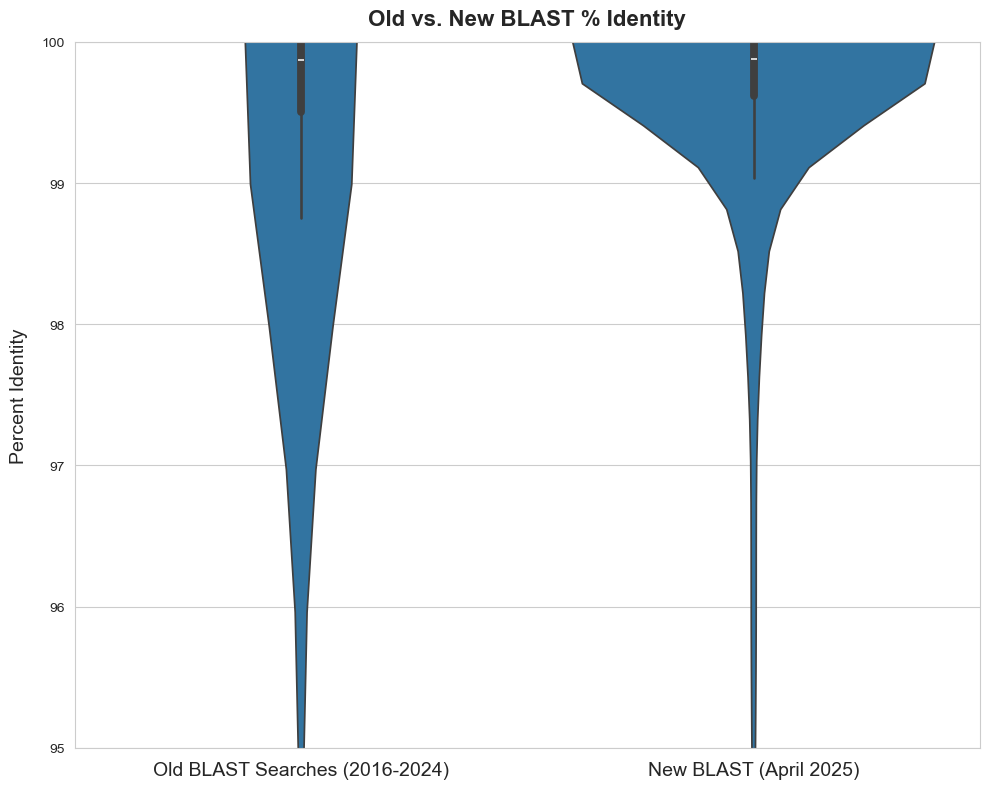

In [70]:
# remap the column names to something more informative
label_map = {
    "Reformatted Old Identity Scores": "Old BLAST Searches (2016-2024)",
    "percent_identity":              "New BLAST (April 2025)"
}

# pick the two columns and melt into long form for seaborn
df = identity_score_data[[
    "Reformatted Old Identity Scores",
    "percent_identity"
]].dropna().melt(
    var_name="Run",
    value_name="Percent Identity"
)

df["RunLabel"] = df["Run"].map(label_map)



plt.figure(figsize=(10,8))
ax = sns.violinplot(
    data=df,
    x="RunLabel",
    y="Percent Identity",
    # inner parameters: ['box', 'quart', 'stick', 'point', None]
    # quart would draw the 25th/50th/75th percentiles inside
    inner="box",   # we use box to show a small boxplot inside
    # sclae parameter can adjust the density sclae of the plots
    # e.g. ["width", "area", "count"]
    # width = every violin has same maximum width (only compare shape, not quantitative info, so not ideal here
    # area: scales each violin to get wider violins
    # count: linear scaling with observation count
    density_norm="area",
    cut=0               # don’t extend past your data
)

# relabel axes
ax.set_xlabel("",             # drop the x-axis label if you like
              fontsize=14,    # x-label font size
              labelpad=8)     # space below the label

ax.set_ylabel("Percent Identity",
              fontsize=14,
              labelpad=10)
ax.set_title("Old vs. New BLAST % Identity",
             fontsize=16,      # title font size
             fontweight="bold",# or "normal", "semibold"
             pad=12)           # space above the plot

ax.tick_params(axis="x",      # x or y or both
               labelsize=14,  # tick label font size
               rotation=0,    # rotate x-labels if they’re crowded
               pad=6)         # distance ticks → tick labels

# adjust y-range
ax.set_ylim(95,100)

plt.tight_layout()
plt.show()

## Taxonomy Distribution

In [60]:
# import the full dataset
taxnomoy_data = pd.read_excel("data/clean_data/expanded_diagnostics_data_2016_2024.xlsx")

### Species Distribution within Genus

In [215]:
def plot_species_distribution_within_genus(
    genus,
    pct_threshold: float = 2.5,
    rare_count_threshold: int = 5,
    expand_other_in_barcharts: bool = True,
    palette="tab20"
):
    """
    For the given genus, draws
     1) a pie chart of species % shares (grouping all species < pct_threshold into 'Other'), and
     2) a horizontal bar chart of raw counts (grouping as 'Other' only if > rare_count_threshold species are rare).
     3) a stacked barchart of species distribution over time
    """
    # filter rows to only this genus (case-insensitive)
    subset = identity_score_data[
        identity_score_data["Genus"].str.lower() == genus.lower()
    ]

    # Print an error message in case there provided genus is not found within the database
    if subset.empty:
        print(f"No records found for genus '{genus}'.")
        return

    # count how many sequences of each species
    counts = subset["Species"].value_counts()
    total = counts.sum()

    # compute each species’ percentage
    pct = counts / total * 100

    # identify which species are “rare”
    rare_species = pct[pct < pct_threshold].index

    # setting up a color palette for my plot (independent of species quantity within genus)
    species_quantity = len(subset["Species"].unique())
    palette = sns.color_palette(palette, species_quantity)


    # --------------------------------------------------------------------------------------
    # PIE CHART (always group rare species into 'Other')
    pie_counts = counts.copy()
    if len(rare_species) > 0:
        # remove the rare ones, then add them up under 'Other'
        pie_counts = counts[~counts.index.isin(rare_species)].copy()
        pie_counts["Other"] = counts[rare_species].sum()

    # draw pie
    fig, ax = plt.subplots(figsize=(12,12))

    # setting up a color palette for my plot (independent of species quantity within genus)
    # pick N = number of slices
    n_slices = len(pie_counts)
    # generate exactly N colors from your named palette
    colors = sns.color_palette(palette, n_slices)

    # pie chart properties saved across three variables:
    # wedges (portions of the pie), texts (labels / title), autotext (the percentage numbers or automatically generated content of the wedges)
    wedges, texts, autotexts = ax.pie(
        pie_counts,
        labels=pie_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        textprops={"fontsize": 14, "fontweight": "normal"}  # slice labels
    )


    # modify the species labels large
    for t in texts:
        t.set_fontsize(16)
        t.set_fontweight("normal")
    # modify percentage labels
    for at in autotexts:
        at.set_fontsize(11)
        at.set_color("black")
        at.set_fontweight("normal")

    ax.set_title(
        f"Species Distribution within Genus {genus.title()}\n"
        f"(species with less than 5% representation <{pct_threshold}% grouped as Other)",
        fontsize=18,
        fontweight="bold",
        pad=12
    )


    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------------------------
    # BAR CHART (group only if there are many rare species)
    # we use an optional (usually empty) subtitle that can expand the plot of the rare_count_threshold is passed and many species grouped into "other"
    if expand_other_in_barcharts is False:
        if len(rare_species) > rare_count_threshold:
            bar_counts = pie_counts
            subtitle = f" (rare species grouped)"
        else:
            bar_counts = counts
            subtitle = ""
    else:
        bar_counts = counts
        subtitle = ""

    fig, ax = plt.subplots(figsize=(12,12))

    bar_counts.plot(kind="barh",
                    ax=ax
                    )

    # edit tick label size for both axes
    ax.tick_params(axis="both",      # or "x" / "y"
                   labelsize=14)    # your desired size


    ax.set_xlabel("Number of Sequences",
                  fontsize=16,
                  fontweight='bold',
                  labelpad=8
                  )
    ax.set_ylabel("Species",
                  fontsize=16,
                  fontweight='bold',
                  labelpad=8
                  )
    ax.set_title(f"{genus.title()} Species Counts{subtitle}",
                 fontsize=18,
                 fontweight="bold",
                 pad=12
                 )

    plt.tight_layout()
    plt.show()


    # --------------------------------------------------------------------------------------
    # STACKED BARCHART: SPECIES PERCENTAGE OVER TIME
    # build a Year×Species table of counts
    year_counts = (
        subset
          .groupby(["Year","Species"])
          .size()
          .unstack(fill_value=0)   # years as rows, species as columns
    )

    # convert to proportions *per year*
    year_frac = year_counts.div(year_counts.sum(axis=1), axis=0)

    # plot a 100%-stacked bar chart
    fig, ax = plt.subplots(figsize=(12,12))


    # setting up a color palette for my plot (independent of species quantity within genus)
    species = year_frac.columns.tolist()
    n_species = len(species)
    palette = sns.color_palette(palette, n_species)


    # draws stacked barchart
    year_frac.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=palette
    )

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    ax.tick_params(axis="both", labelsize=14)


    ax.set_ylabel("Percent of Sequences",
                  fontsize=16,
                  fontweight='bold',
                  labelpad=8
                  )

    ax.set_xlabel("Percent of Sequences",
              fontsize=16,
              fontweight='bold',
              labelpad=8
              )

    ax.set_title(f"{genus.title()} Species Distribution Over Time (100% stacked)",
                 fontsize=18,
                 fontweight="bold",
                 pad=12
                 )

    # legend now works automatically
    ax.legend(title="Species",
              bbox_to_anchor=(1.05,1),
              loc="upper left"
              )

    # ensures the years are shown horizontally
    # NOTE: The semicolon at the end of the statement prevents printing xtick array to the console
    plt.xticks(rotation=0);

    plt.tight_layout()
    plt.show()

### Phyttophtora Species Distribution

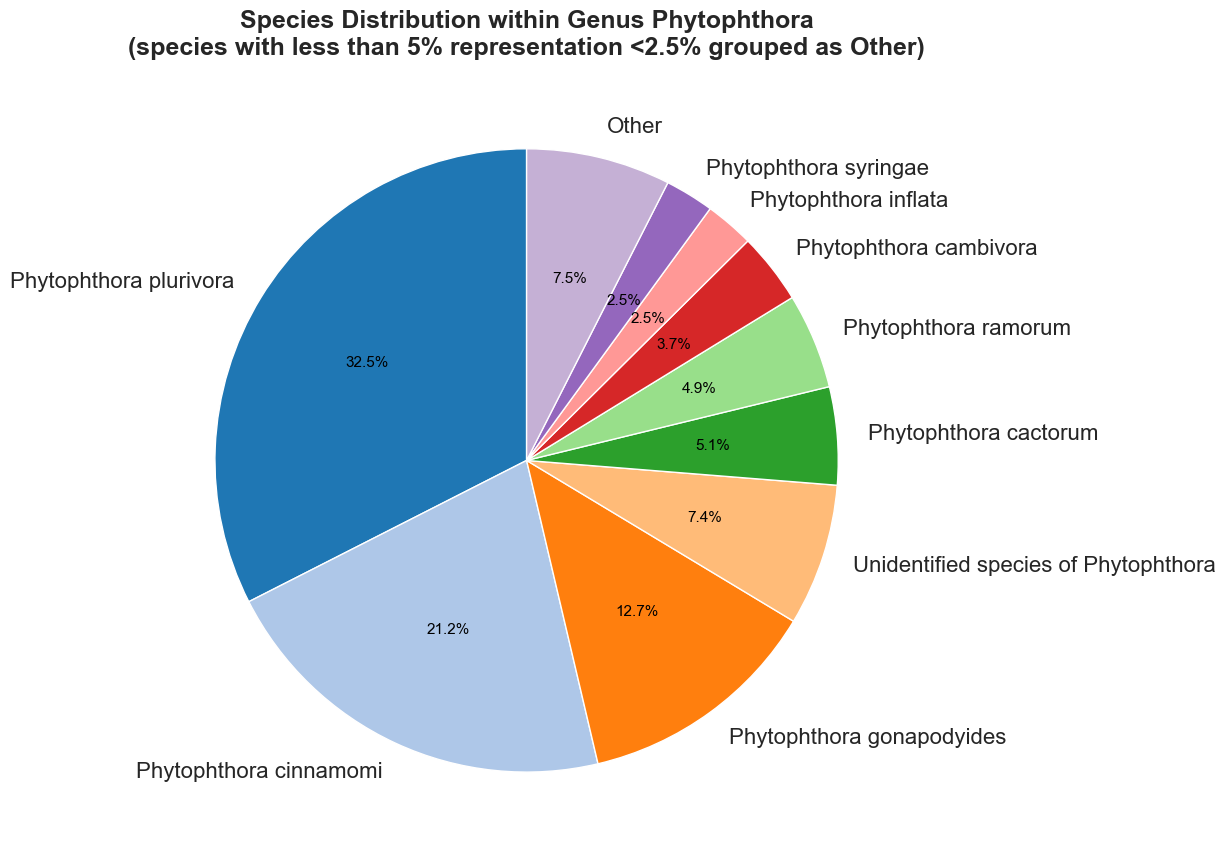

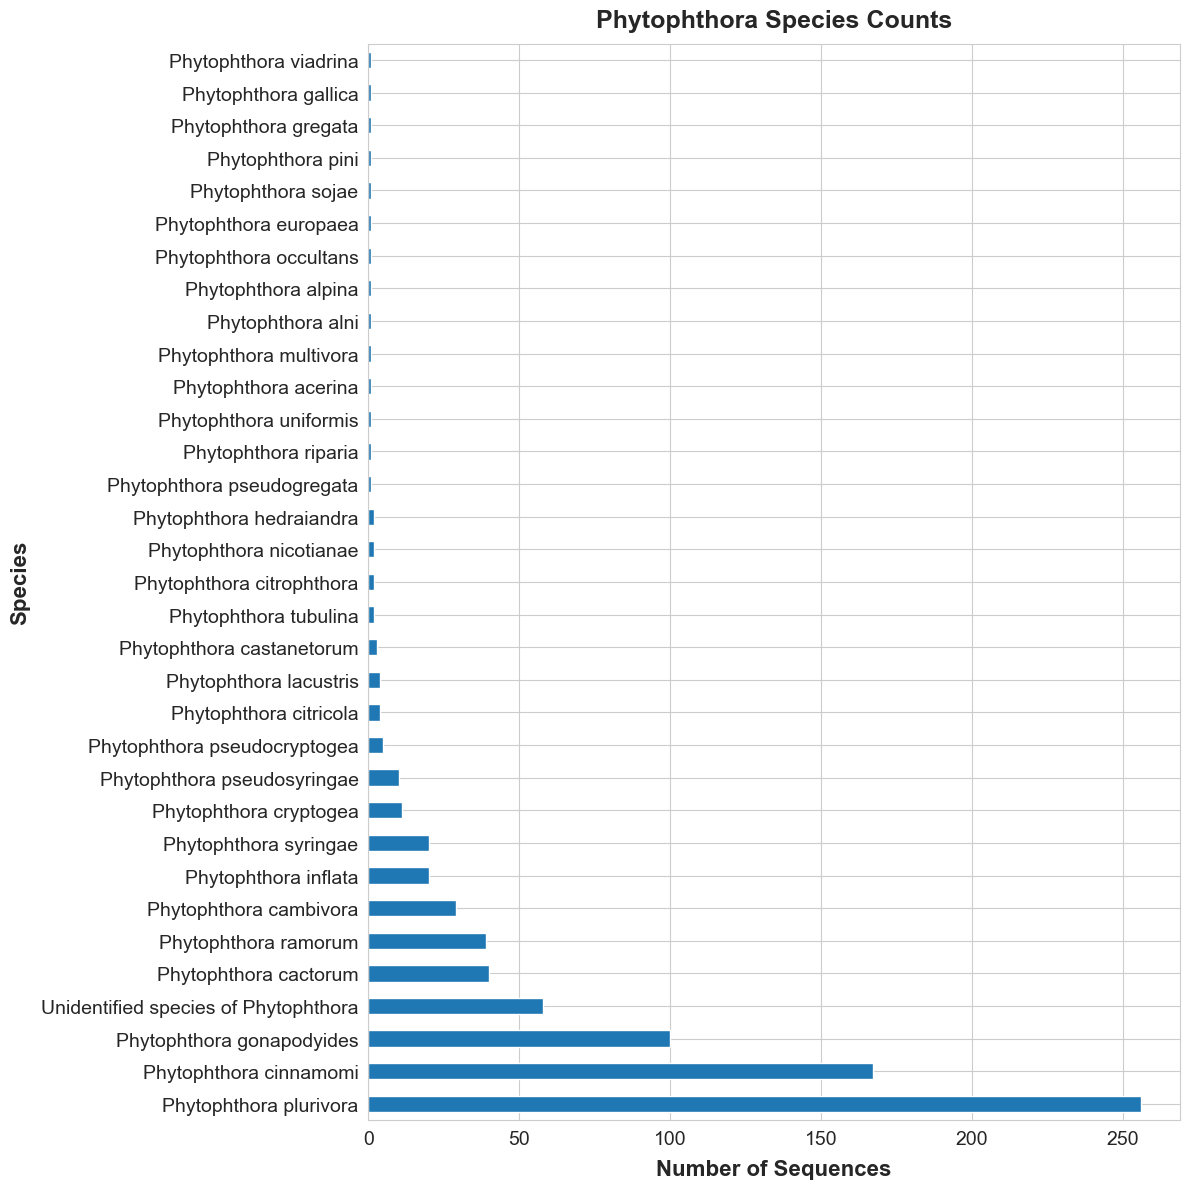

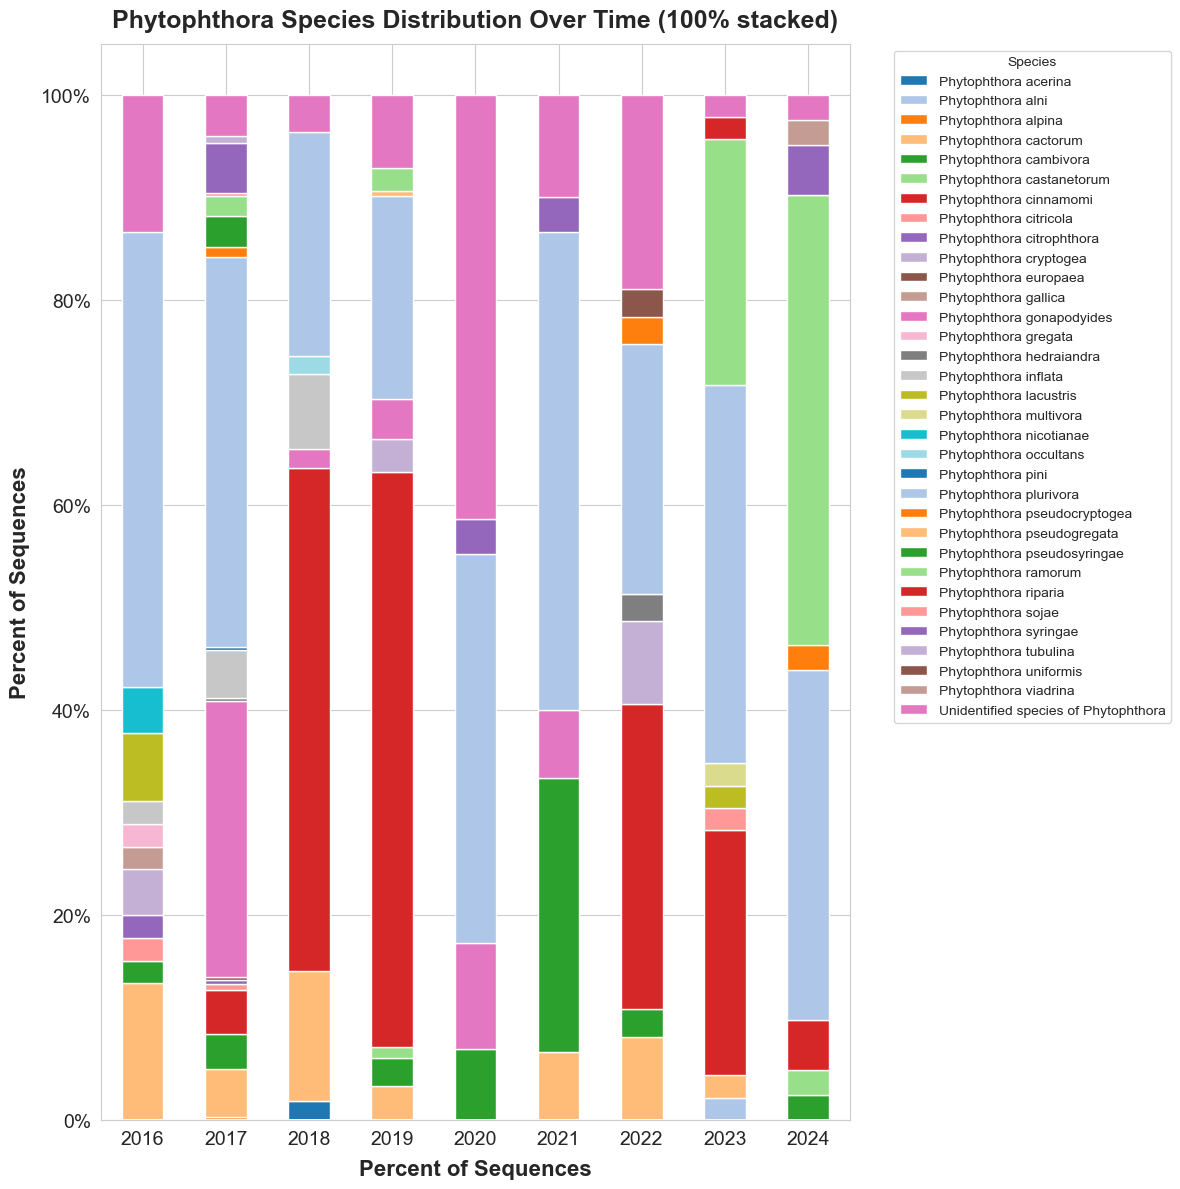

In [216]:
plot_species_distribution_within_genus("Phytophthora", expand_other_in_barcharts=True)

### Monochamus Species Distribution

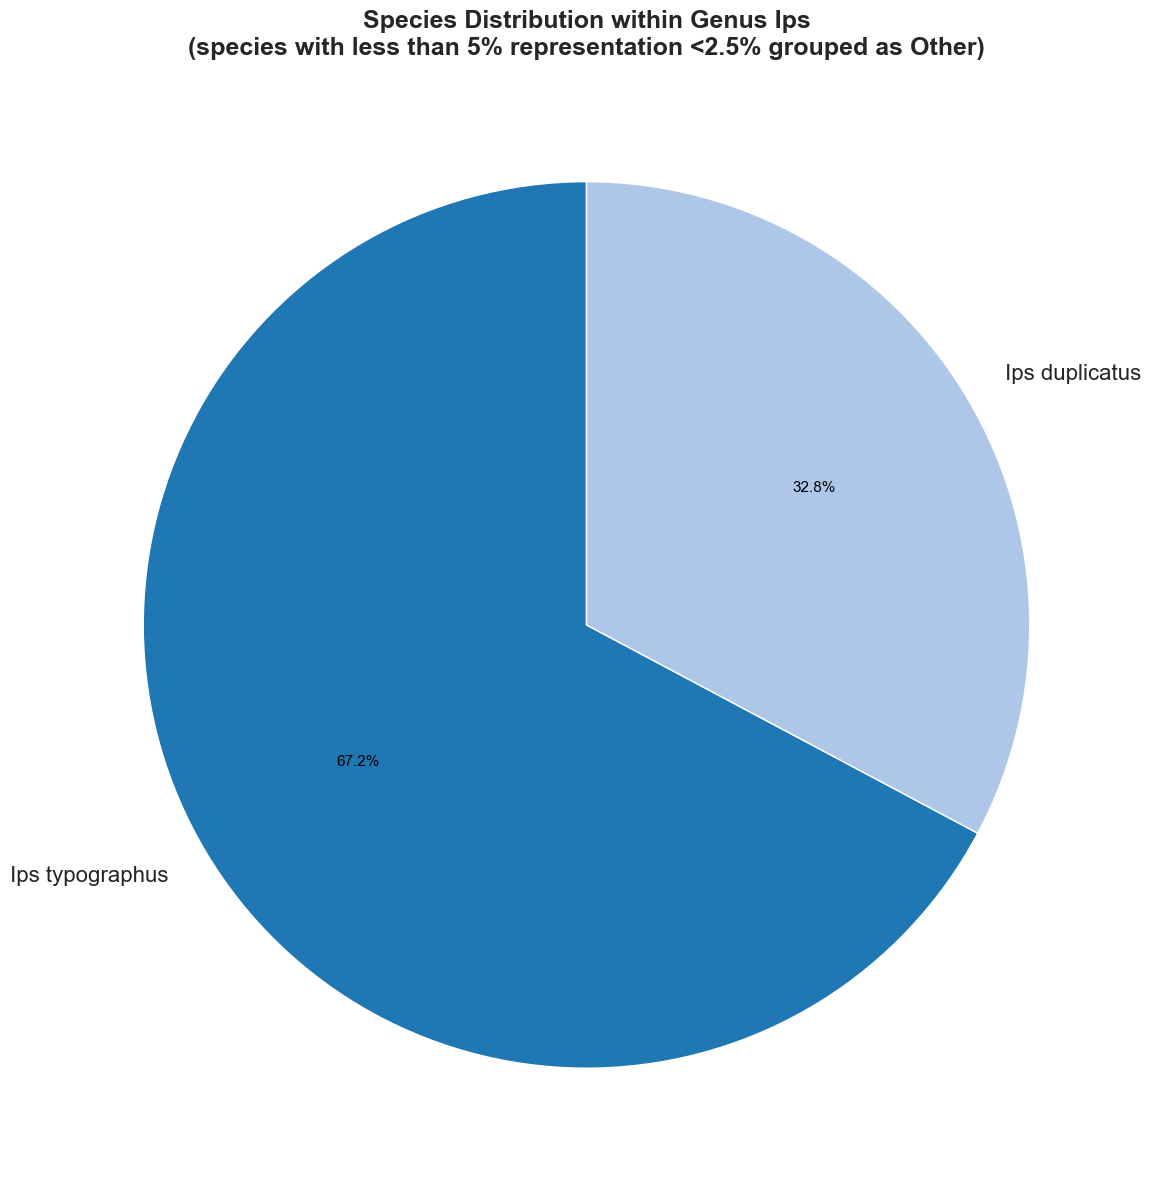

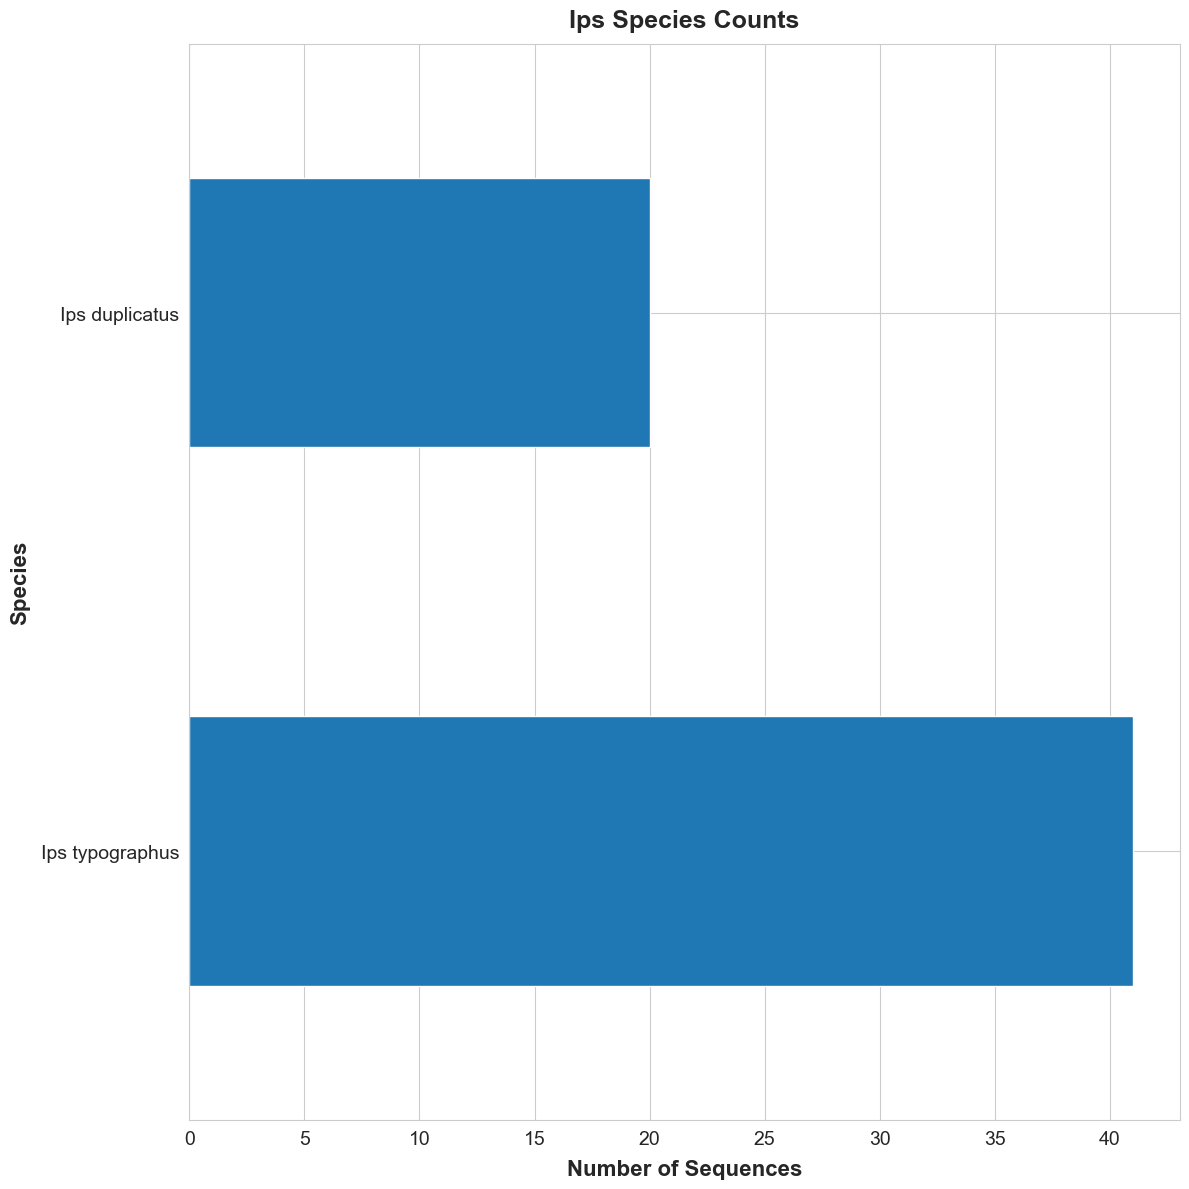

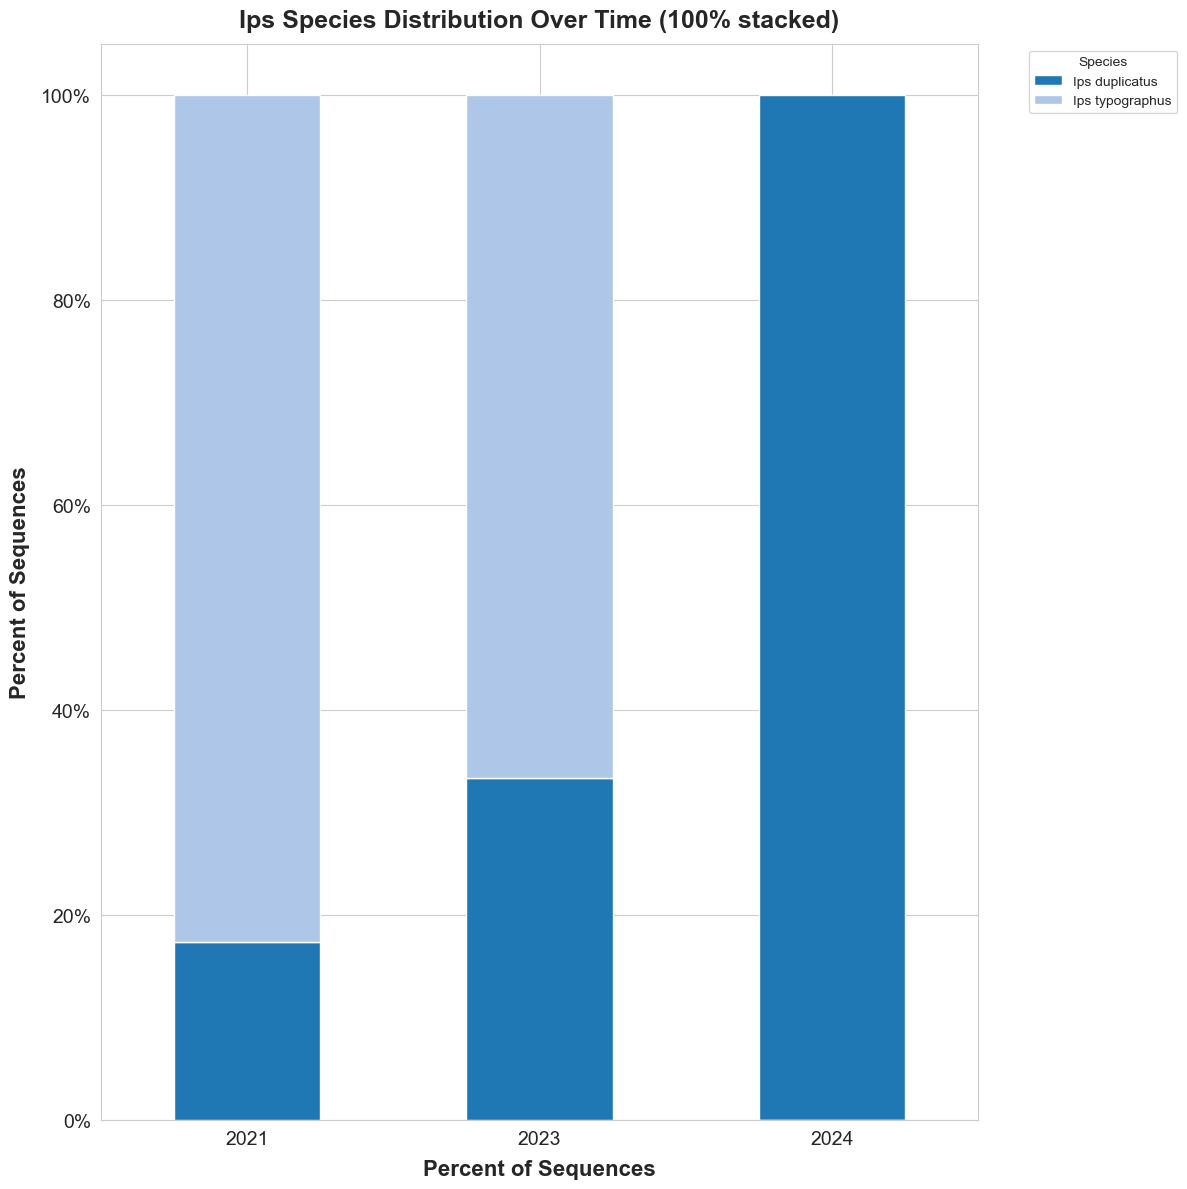

In [217]:
plot_species_distribution_within_genus("Ips", expand_other_in_barcharts=True)

### Ips Species Distribution

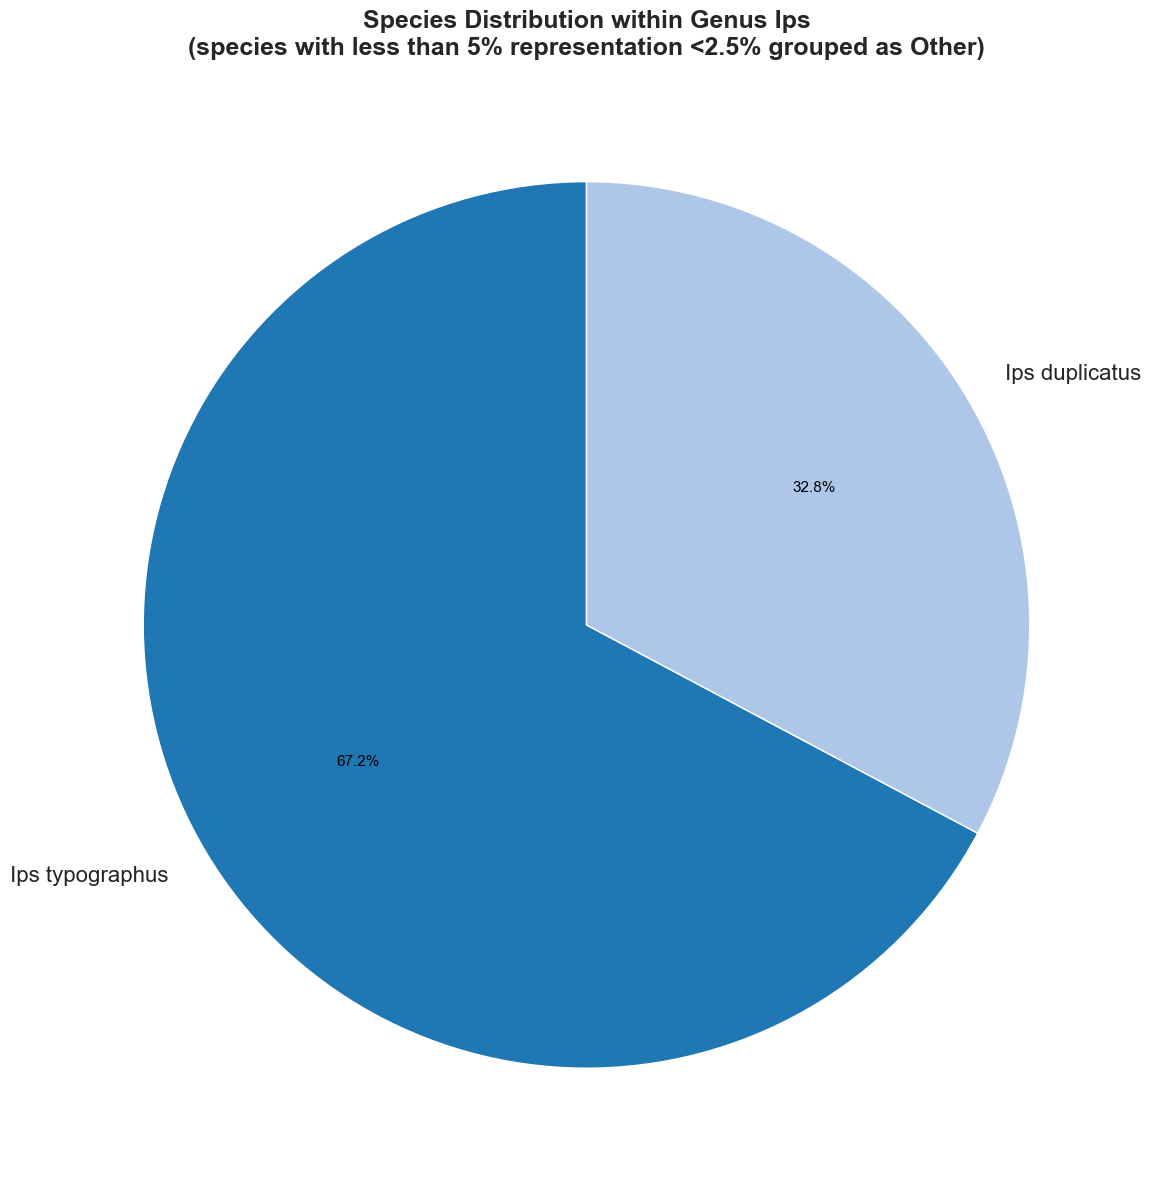

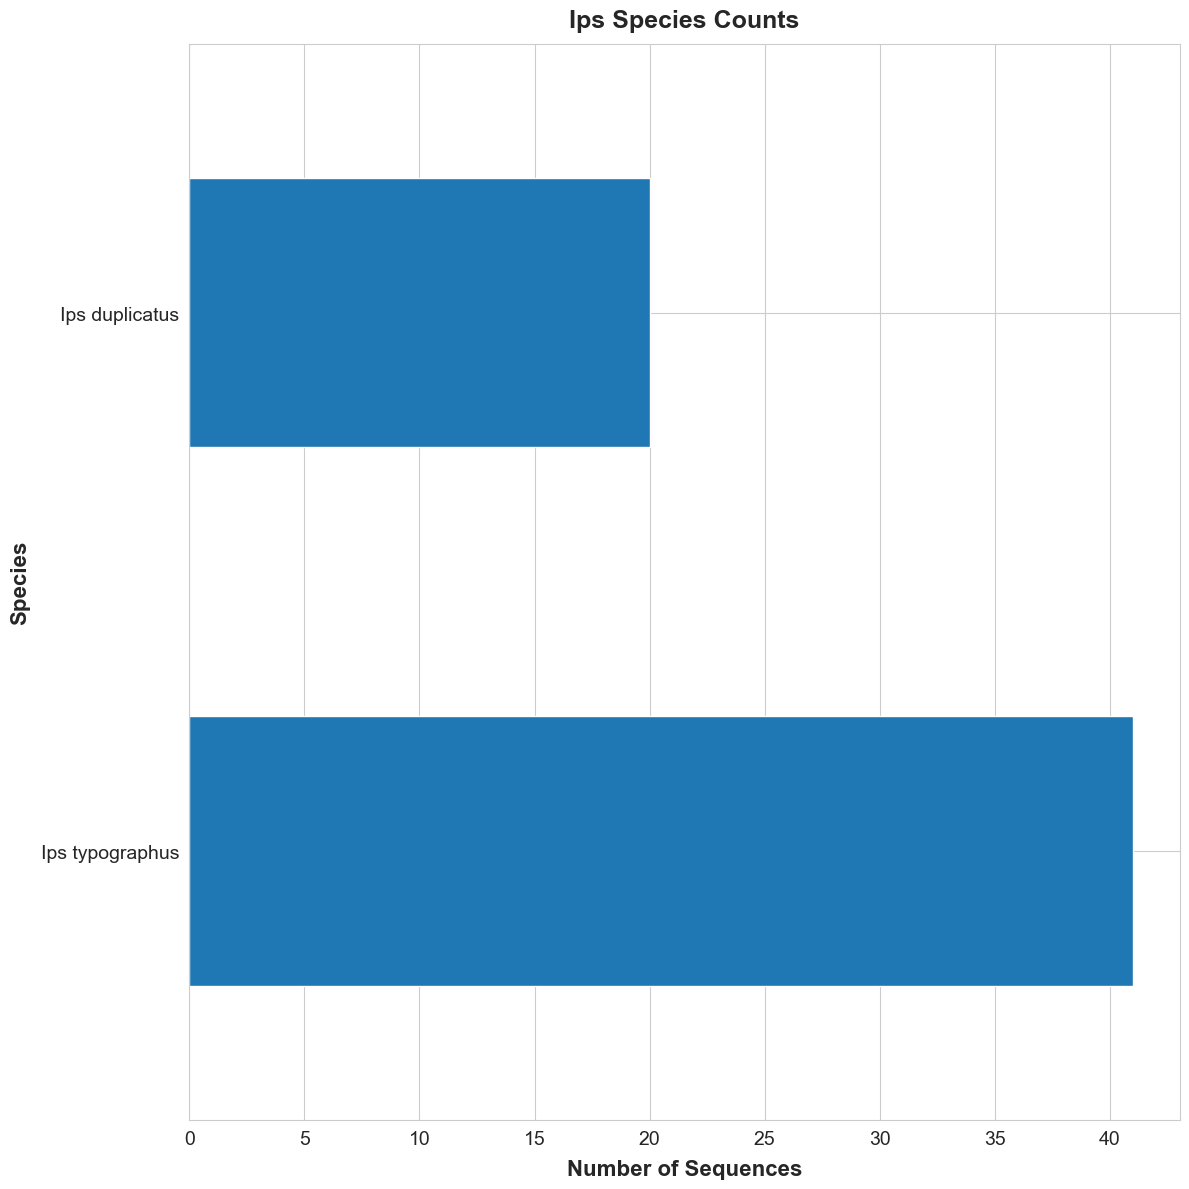

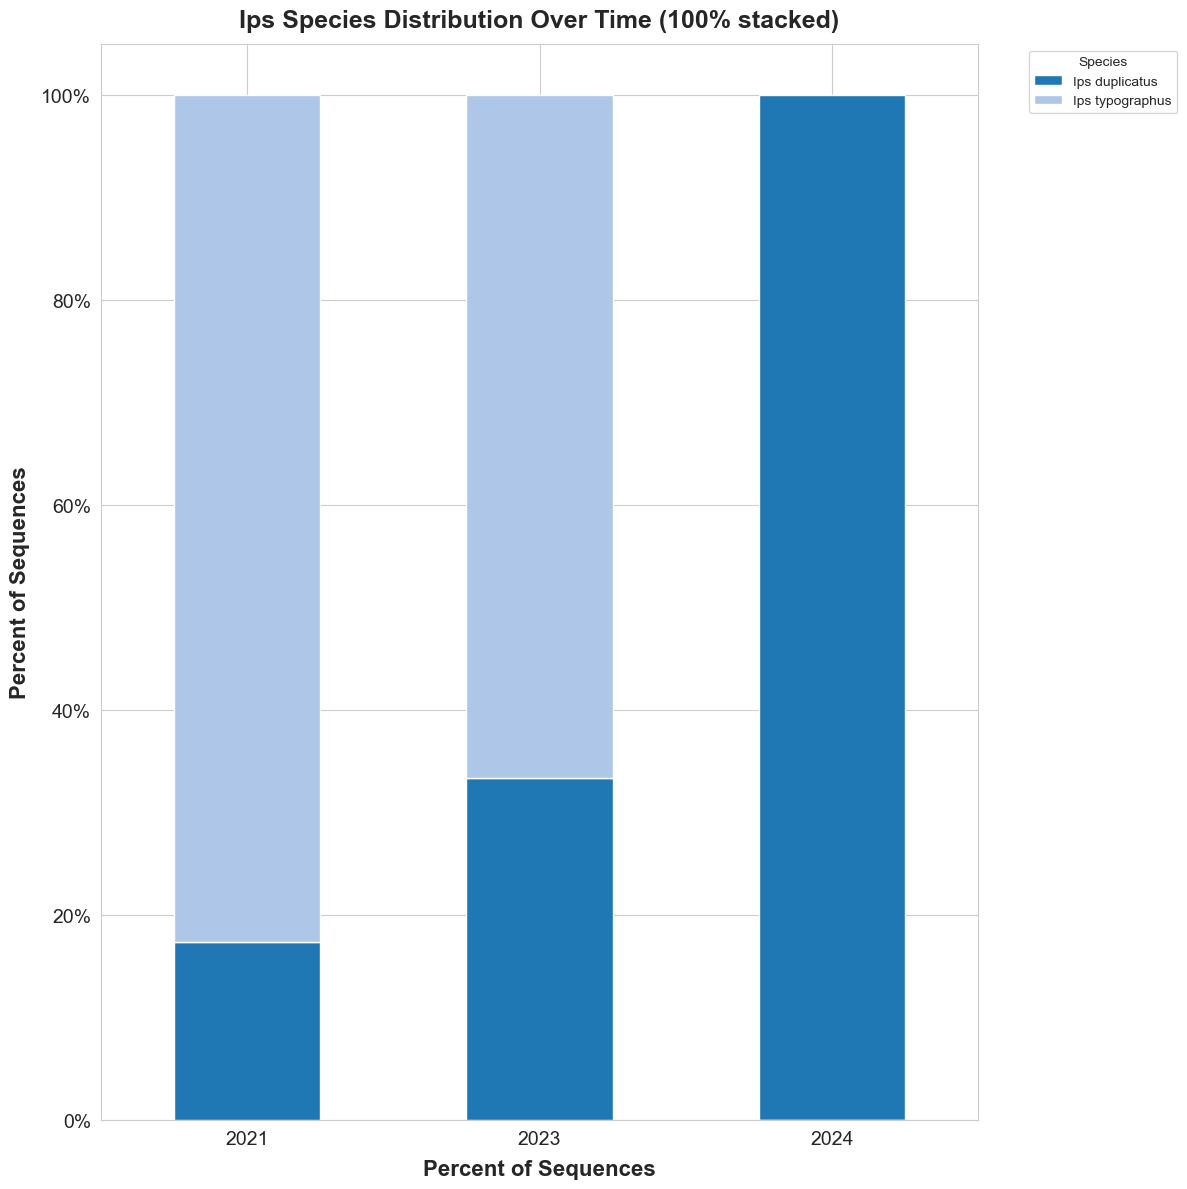

In [218]:
6plot_species_distribution_within_genus("Ips", expand_other_in_barcharts=True)

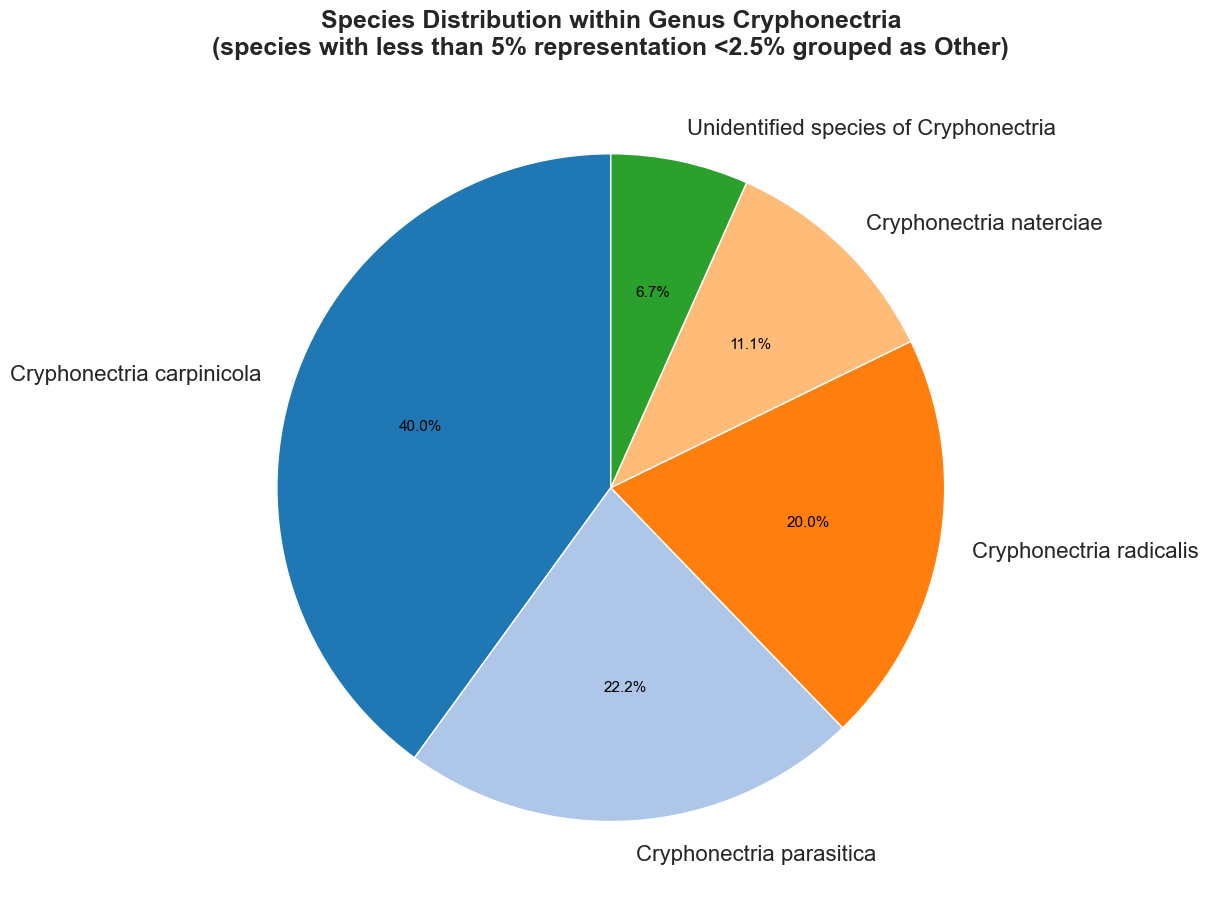

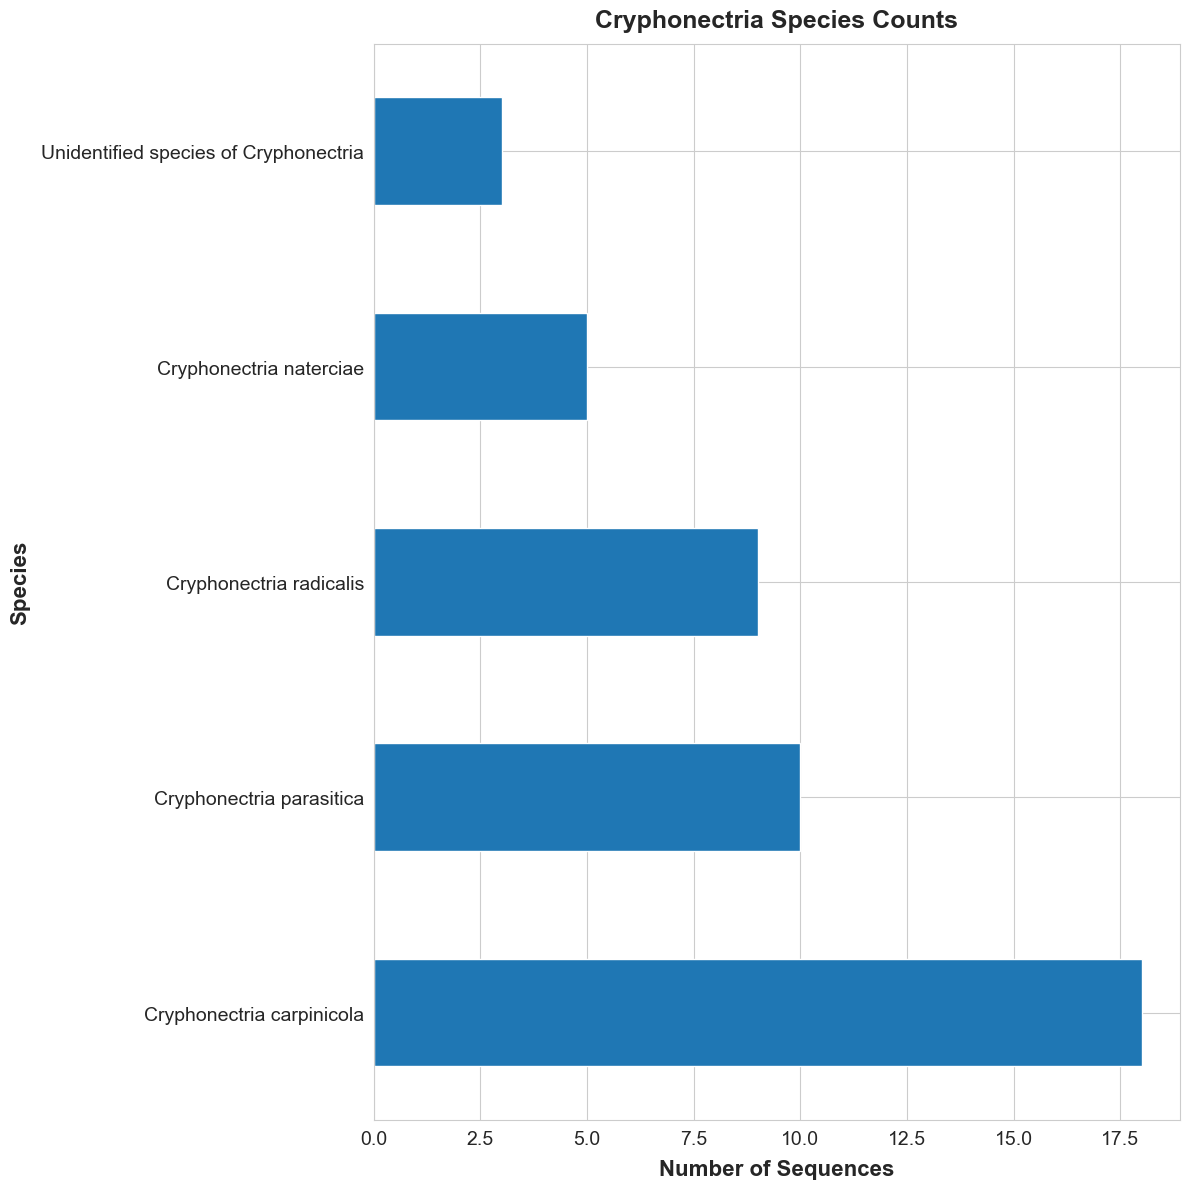

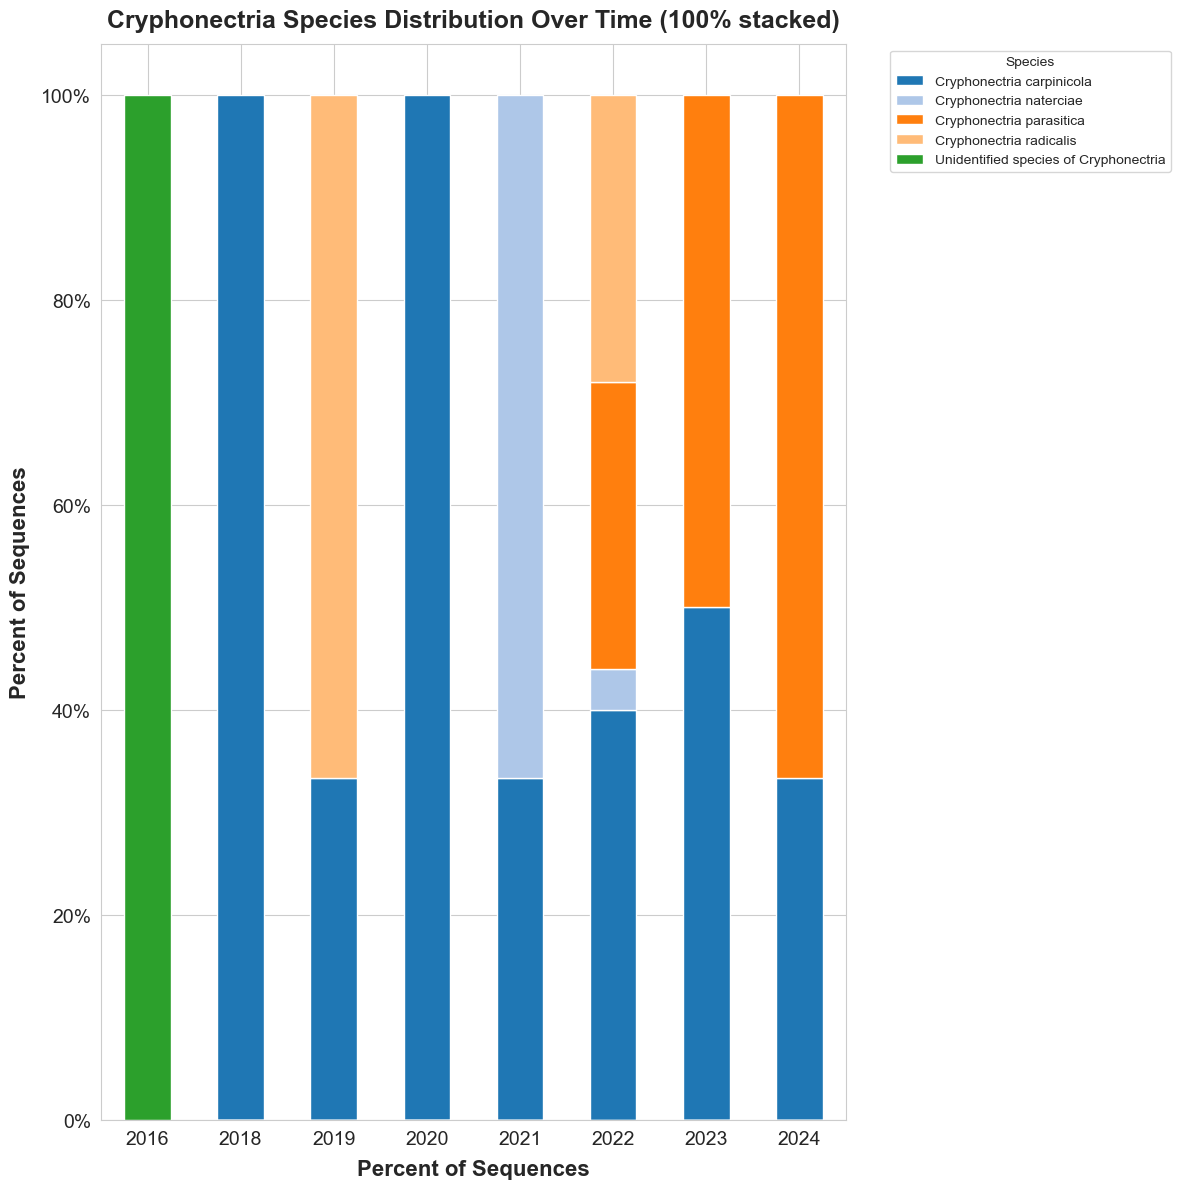

In [219]:
plot_species_distribution_within_genus("Cryphonectria", expand_other_in_barcharts=True)

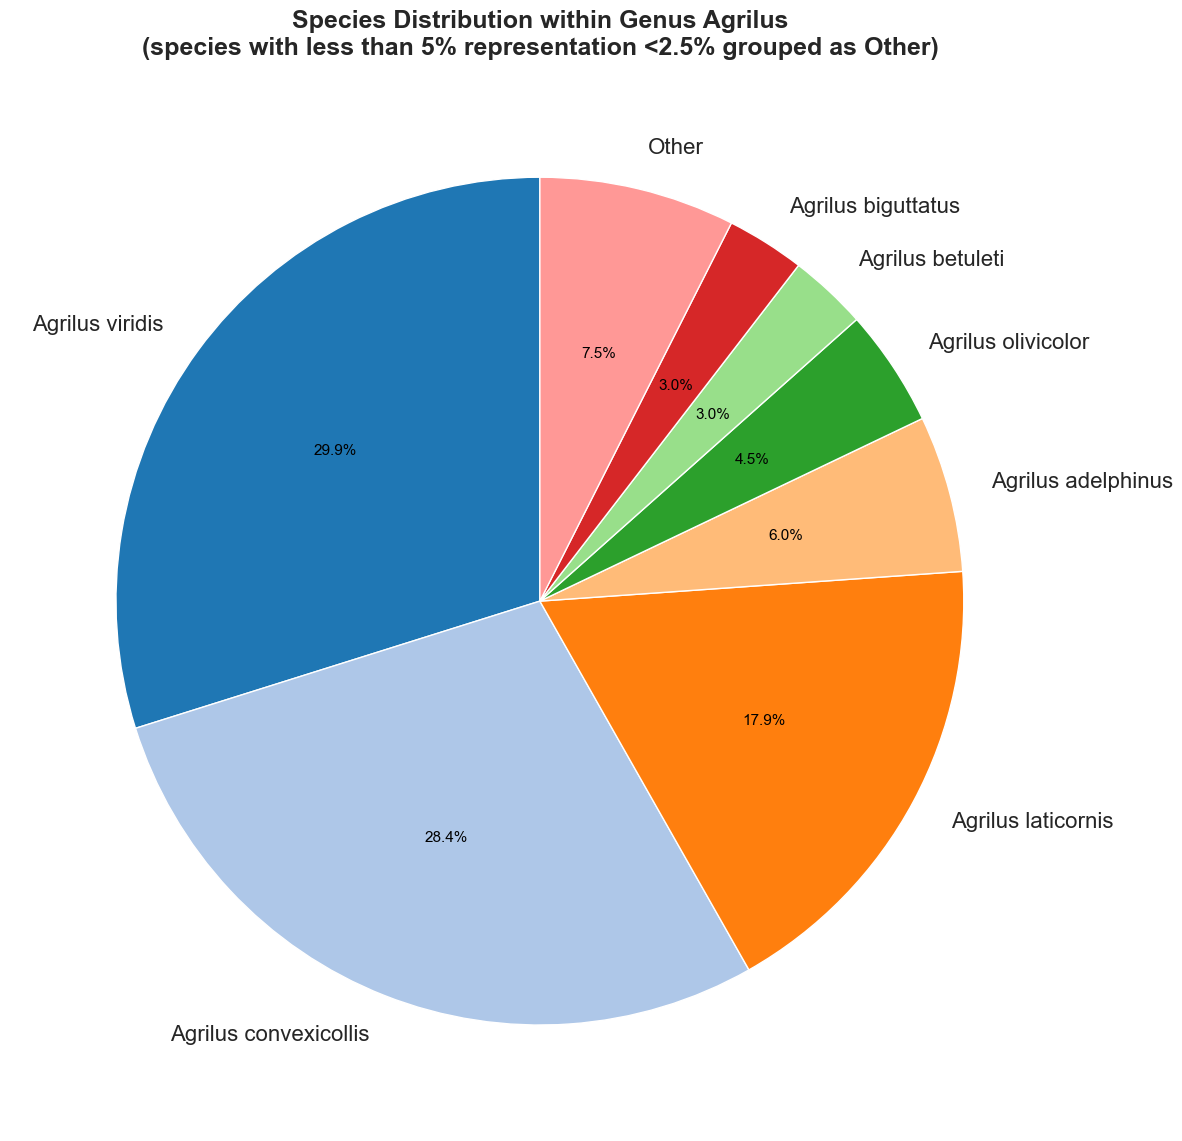

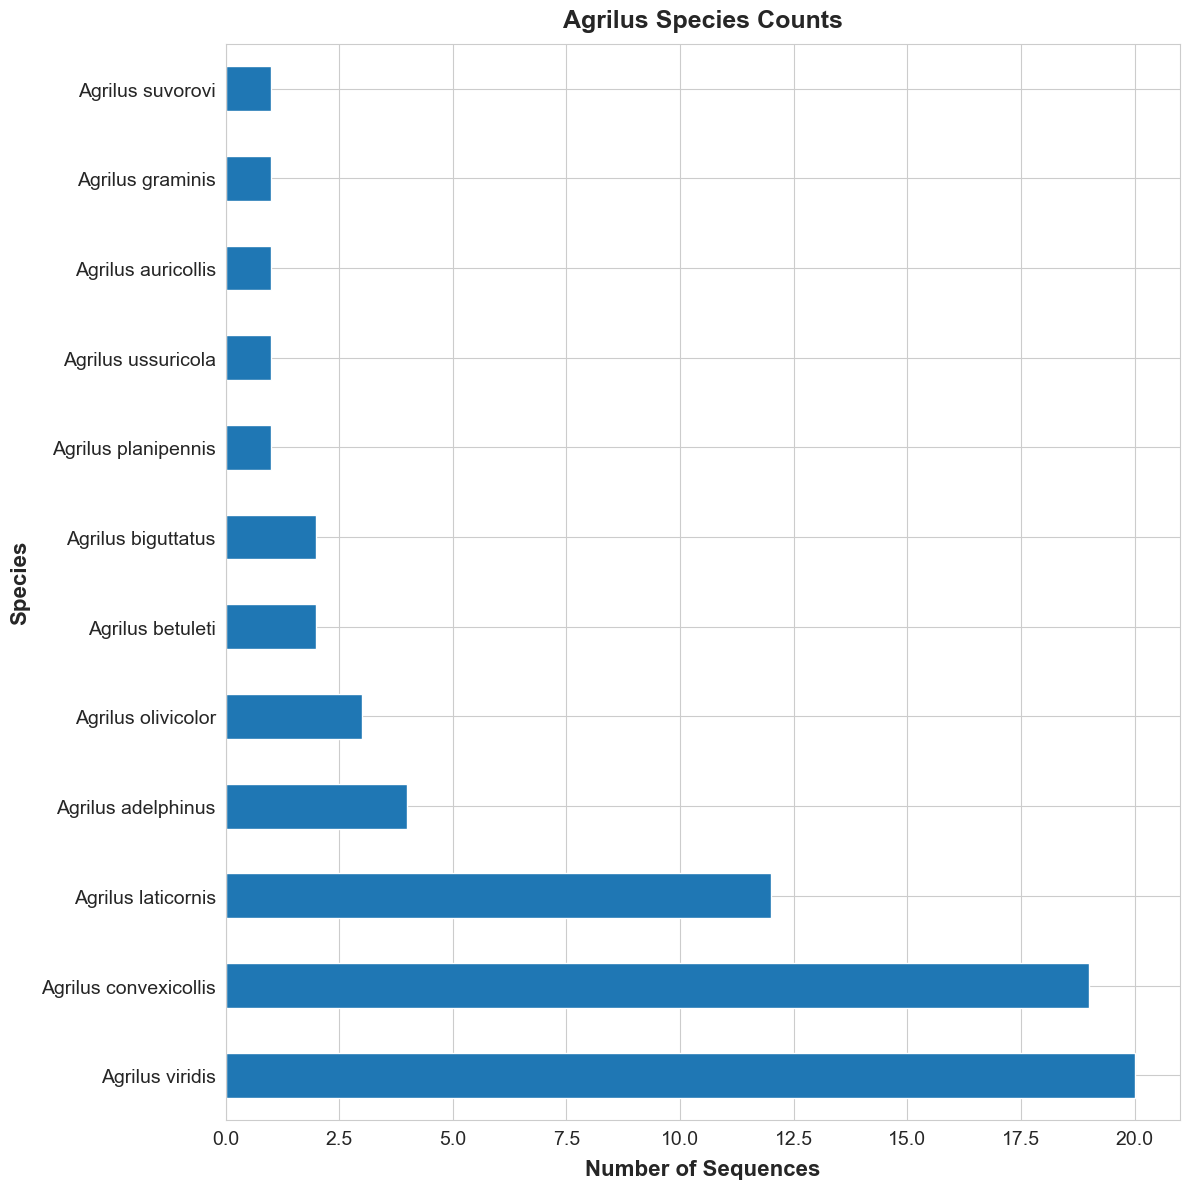

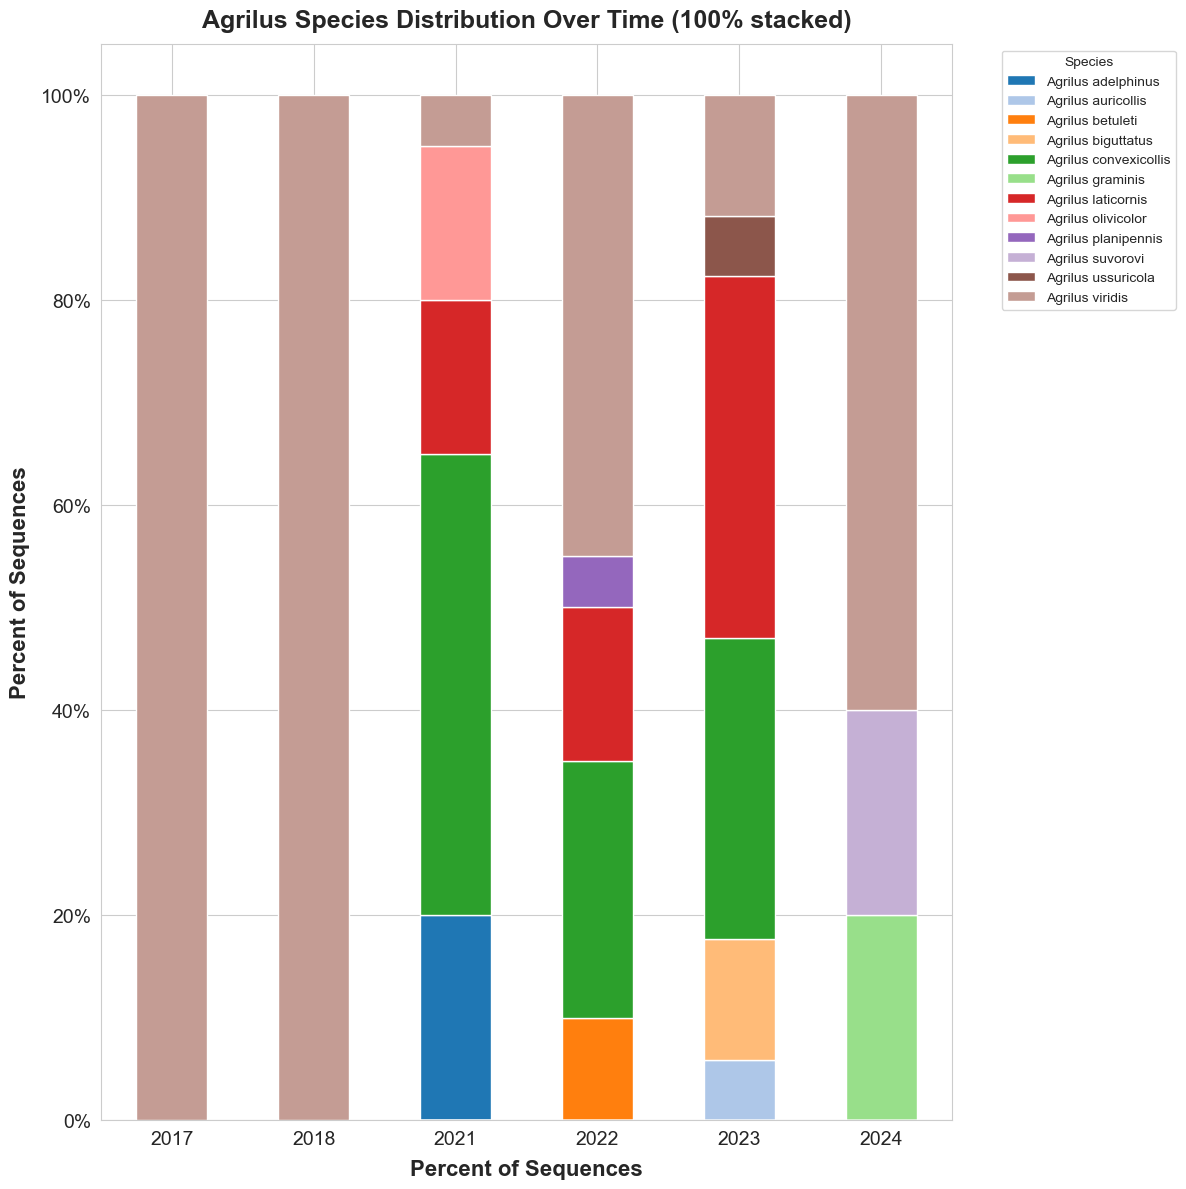

In [220]:
plot_species_distribution_within_genus("Agrilus")